# <center> Advanced Vehicle Detection </center>

In [1]:
import matplotlib.image as mpimg
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip

%matplotlib inline

orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial = 16
hist_bins = 32
colorspace = 'LUV' #'RGB'
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_bin_flag=True
color_hist_flag=True
# saving model
filename1 = 'vd-linearsvc.pkl'
filename2 = 'vd-xscaler.pkl'

## Read images of vehicles and non-vehicles

read vehicles
8792 vehicles found
read non-vehicles
8968 non-vehicles found


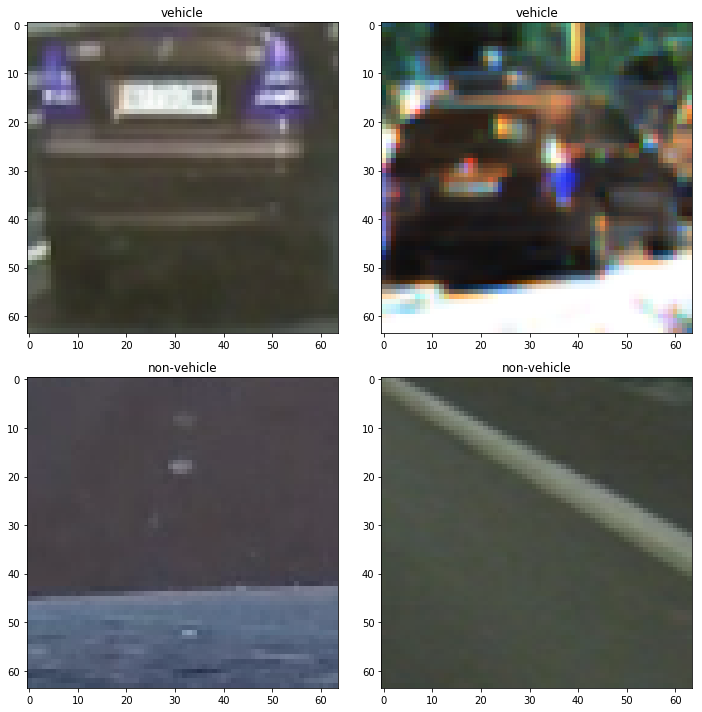

In [13]:
cars = []
notcars = []

#vehicle
print('read vehicles')
files = glob.glob('vehicles/*/*.png')

for file in files:
    cars.append(file)

print(len(cars), 'vehicles found')
    
#non vehicle   
print('read non-vehicles')
files = glob.glob('non-vehicles/*/*.png')

for file in files:
    notcars.append(file)
    
print(len(notcars), 'non-vehicles found')

f, axarr = plt.subplots(2, 2, figsize=(10,10))
axarr[0,0].imshow(cv2.imread(cars[1001]))
axarr[0,0].set_title('vehicle')
axarr[0,1].imshow(cv2.imread(cars[8000]))
axarr[0,1].set_title('vehicle')
axarr[1,0].imshow(cv2.imread(notcars[1001]))
axarr[1,0].set_title('non-vehicle')
axarr[1,1].imshow(cv2.imread(notcars[7000]))
axarr[1,1].set_title('non-vehicle')
plt.tight_layout()



#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for extracting features including HOG are defined in the below 3 cells. 

I unzipped vehicle and non-vehicle datasets and started by reading in all the `vehicle` and `non-vehicle` images.  
I tried udacity dataset but it was crashing chrome as it was too big dataset. Random images of vehicle and non-vehicle are shown above.

I explored different color spaces YCrCb, LUV, HSV and saw the better accuracy with YCrCb colorspace. I played with different values of `orientations`, `pixels_per_cell`, and `cells_per_block` but I used the values as we had them in the learning videos and practice [orient = 9, pix_per_cell = 8, cell_per_block = 2]. I also used spatial bin with size (16,16) as training images were of size (64,64). I also used hist_bins for the intensity and kept it (32,32).
I used `skimage.hog()` for HOG features extraction. After experimenting, I used only channel=0 for the feature extraction only.

Visualization of applying colorspace and HOG features ( for each channel) for random vehicle and non-vehicle images is shown starting two cells below. 

In [2]:
#helper functions
def convert_colorspace(img, conv):
    
    if conv == 'RGB':
        return np.copy(img)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def bin_spatial(img, size):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


## HOG Classifier

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Visualize HOG extraction of vehicle
Visualizing HOG feature of each channel on the original RGB and then converted to YCrCb colorspace.

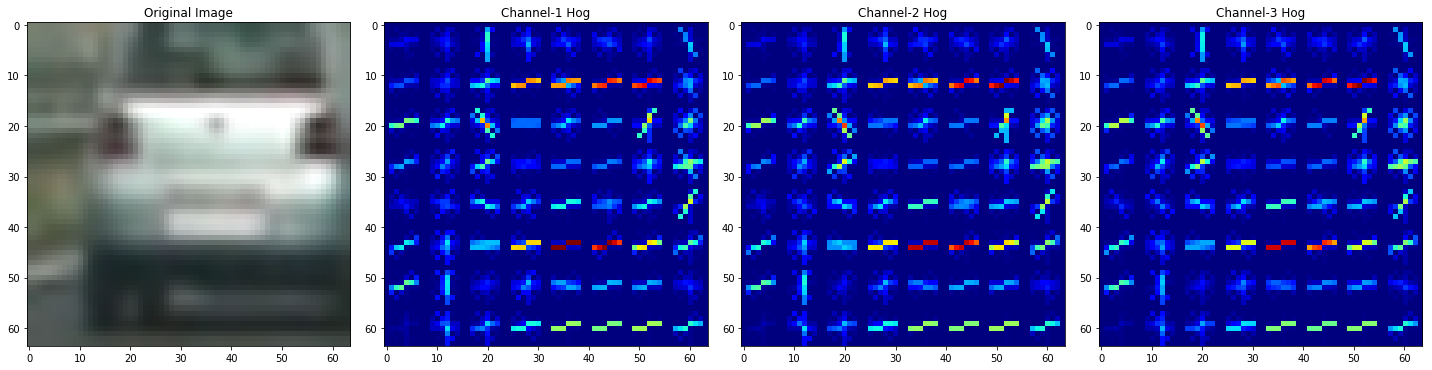

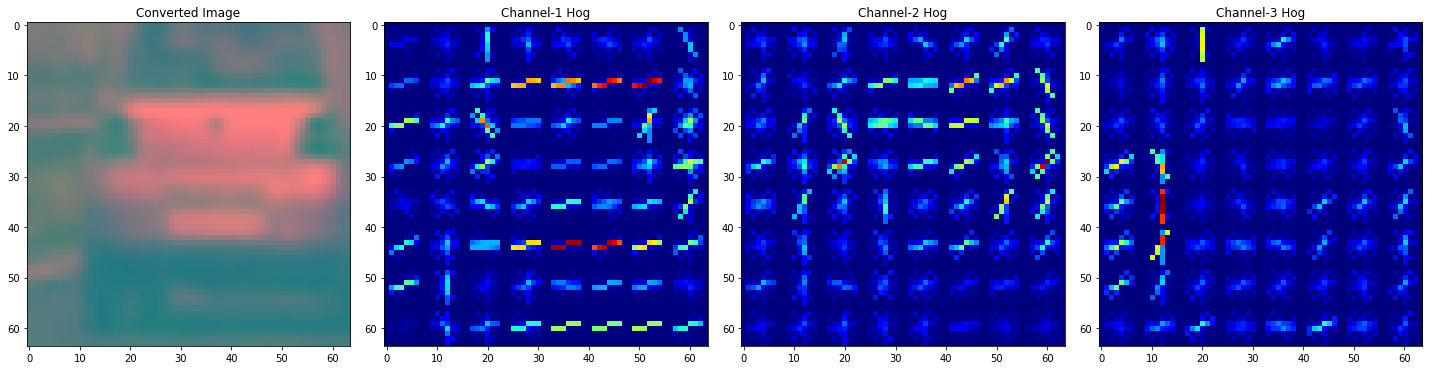

In [6]:
orient=9
pix_per_cell=8
cell_per_block=2

img = mpimg.imread(cars[100])

fig = plt.figure(figsize=(20,10))
plt.subplot(141)
plt.imshow(img)
plt.title('Original Image')

_, img1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(142)
plt.imshow(img1, cmap='jet')
plt.title('Channel-1 Hog')

_, img2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(143)
plt.imshow(img2, cmap='jet')
plt.title('Channel-2 Hog')

_, img3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(144)
plt.imshow(img3, cmap='jet')
plt.title('Channel-3 Hog')
fig.tight_layout()

img = convert_colorspace(img, conv='RGB2YCrCb')

fig = plt.figure(figsize=(20,10))
plt.subplot(141)
plt.imshow(img, cmap='gray')
plt.title('Converted Image')

_, img1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(142)
plt.imshow(img1, cmap='jet')
plt.title('Channel-1 Hog')

_, img2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(143)
plt.imshow(img2, cmap='jet')
plt.title('Channel-2 Hog')

_, img3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(144)
plt.imshow(img3, cmap='jet')
plt.title('Channel-3 Hog')

fig.tight_layout()


# Visualize HOG extraction of non-vehicle
Visualizing HOG feature of each channel on the original RGB and then converted to YCrCb colorspace.

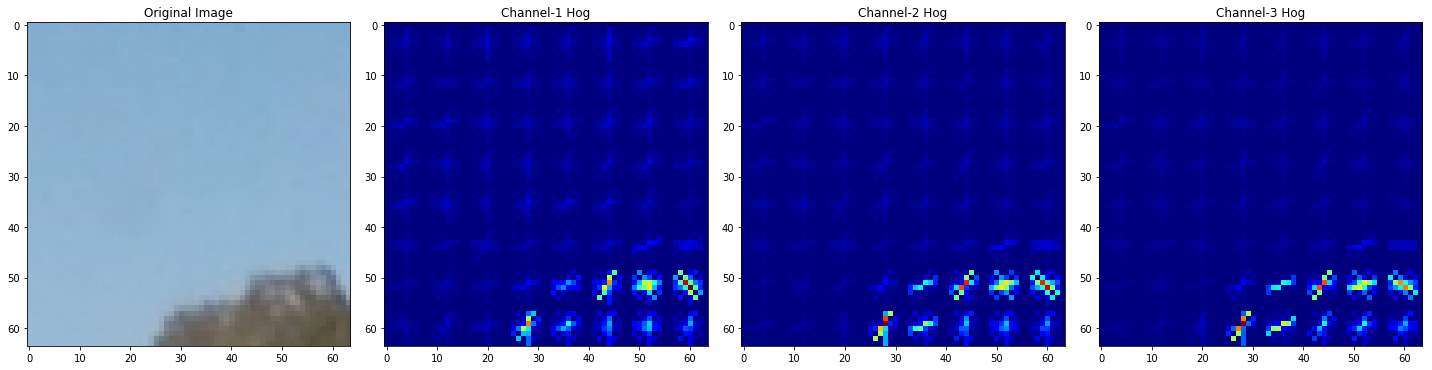

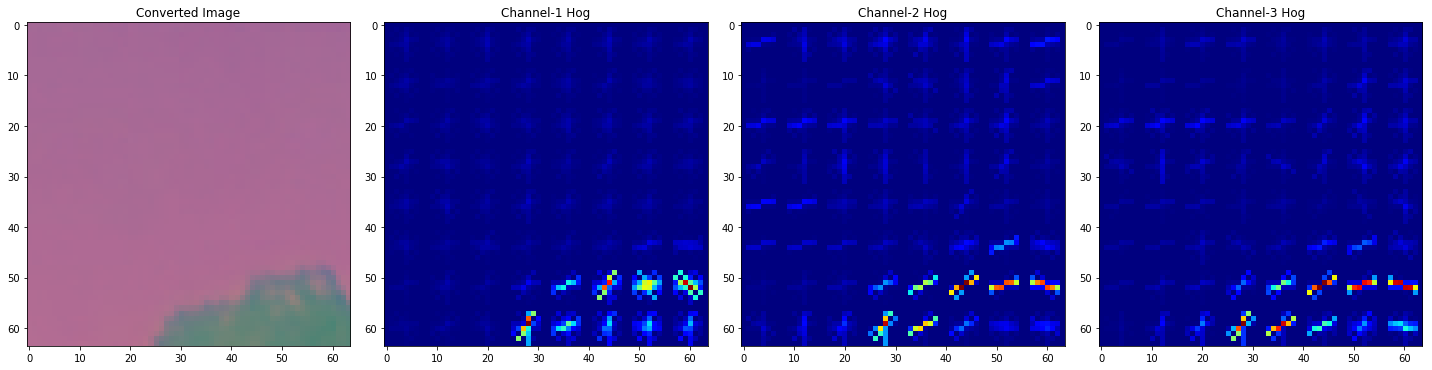

In [7]:
orient=9
pix_per_cell=8
cell_per_block=2

img = mpimg.imread(notcars[1000])

fig = plt.figure(figsize=(20,10))
plt.subplot(141)
plt.imshow(img)
plt.title('Original Image')

_, img1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(142)
plt.imshow(img1, cmap='jet')
plt.title('Channel-1 Hog')

_, img2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(143)
plt.imshow(img2, cmap='jet')
plt.title('Channel-2 Hog')

_, img3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(144)
plt.imshow(img3, cmap='jet')
plt.title('Channel-3 Hog')
fig.tight_layout()

img = convert_colorspace(img, conv='RGB2YCrCb')

fig = plt.figure(figsize=(20,10))
plt.subplot(141)
plt.imshow(img)
plt.title('Converted Image')

_, img1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(142)
plt.imshow(img1, cmap='jet')
plt.title('Channel-1 Hog')

_, img2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(143)
plt.imshow(img2, cmap='jet')
plt.title('Channel-2 Hog')

_, img3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.subplot(144)
plt.imshow(img3, cmap='jet')
plt.title('Channel-3 Hog')

fig.tight_layout()


#### 2. Explain how you settled on your final choice of HOG parameters.

I kept pixel_per_cell=8 and cell_per_block=2, as per the lecture lessons. I did experiment with orientation between 6 and 12 but settled for 9 like in the lecture lessons. I experimented with three colorspaces only YCrCb, LUV and HSV as they handle shades better. I experimented with and without using spatial bin and color histogram but in the final training, I used both of them. Since training images were of size 64,64, I tried using spatial bin of the same size but it was crashing my chrome while running the notebook. So I experimented and reduced it to size (16,16). I experiemnted with using one or all channels for HOG features but observed one channel was sufficient for the feature extraction and training the classifier.    


In [4]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True, debug=False): 
    if debug == True:
        print('color_space', color_space)
        print('spatial size', spatial_size)
        print('hist_bins', hist_bins)
        print('orient', orient)
        print('pix_per_cell', pix_per_cell)
        print('cell_per_block', cell_per_block)
        print('hog_channel', hog_channel)
        print('spatial_feat', spatial_feat)
        print('hist_feat', hist_feat)
        print('hog_feat', hog_feat)
        
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_colorspace(img, conv=color_space)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        if debug == True:
            print("append spatial_feat")
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        if debug == True:
            print("append color_hist_feat")
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            if debug == True:
                print("append all hog channels")

            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [5]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat=True, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the
    for file in imgs:
        
        # Read in each  list ofone by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=True, debug=False) 
        features.append(file_features)
        
        #augment the data
        image = np.fliplr(image)
        file_features = single_img_features(image, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=True, debug=False) 
        features.append(file_features)
        
    # Return list of feature vectors
    return features
    
    

## Extract features of the training data 

In [10]:
print('extract fearures of vehicles')

car_features = extract_features(cars, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_bin_flag, hist_feat=color_hist_flag)

print('extract fearures of non-vehicles')

notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_bin_flag, hist_feat=color_hist_flag)
    
    
print('done')

extract fearures of vehicles
extract fearures of non-vehicles
done


## Normalize the data. Split the training data into the test data

In [11]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# save
joblib.dump(X_scaler, filename2)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 2628


### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I used LinearSVC classifier as per the lecture notes. After lot of experimentation I trained the classifier using converting image to YCrCB colorspace, then applying spatial bin of (16,16), color histogram of (32,32) and HOG channel=0. 

Though during the initial training, test accuracy was very good but prediction was not good. I felt like more training data is needed. So I augmented the training data by flipping the images and re-did the feature extraction. I was able to get better prediction after that.

I also saved the SVC model and scaler in the file, for later use in the code without the need of training the classifier again.

## Train the classifier

In [12]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
print('My SVC predicts: ', svc.predict(X_test), 'For these',len(X_test), 'labels: ', y_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', len(X_test),'labels with SVC')

# now you can save it to a file
joblib.dump(svc, filename1)

# and later you can load it
#clf = joblib.load('vd-linearsvc.pkl')

Using: 9 orientations 8 pixels per cell and 2 cells per block
13.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9816
My SVC predicts:  [ 1.  1.  1. ...,  0.  0.  1.] For these 7104 labels:  [ 1.  1.  1. ...,  0.  0.  1.]
0.0752 Seconds to predict 7104 labels with SVC


['vd-linearsvc.pkl']

### Sliding window and classify 

(720, 1280, 3)


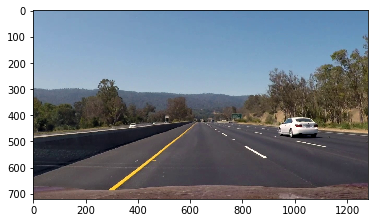

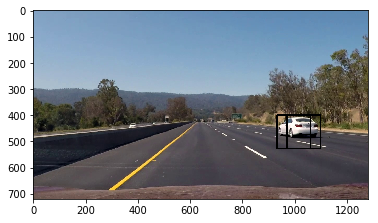

In [6]:
#load
svc = joblib.load(filename1)
X_scaler = joblib.load(filename2)

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    #print('yspan', yspan)
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    #print('nx_windows', nx_windows)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    #print('ny_windows', ny_windows)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            #print('starty',starty)
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    spatial_bin_flag=False, color_hist_flag=False, hog_channel=0):

    #print(color_space)
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #print(window, ' hog channel', hog_channel, hog3.shape)

        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  

        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_bin_flag, hist_feat=color_hist_flag, debug=False)
            
        #print(features)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            #to avoid false positive
            if window[1][0] < 1250 :
                on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

ystart = 400
ystop = 650
scale = 1.5

#image = mpimg.imread('test_images/test4.jpg')
image = mpimg.imread('video_images/frame392.jpg')
print(image.shape)
plt.imshow(image)
plt.figure()

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are x_start_stop = [0, image.shape[1]]searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
x_start_stop = [400, image.shape[1]]
y_start_stop = [ystart, ystop]
xy_window=(128,128)
xy_overlap=(0.85, 0.85)

windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                    xy_window=xy_window, xy_overlap=xy_overlap)

#print(windows)
hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        spatial_size=(spatial, spatial), hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block,
                        spatial_bin_flag=spatial_bin_flag, color_hist_flag=color_hist_flag,
                        hog_channel=hog_channel)                       
#print(hot_windows)
window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 255, 255), thick=4)                    

plt.imshow(window_img)


### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

In the above cell, I started with the calculating sliding windows, the passing it to the search windows method, we I used single_img_features to get all the features ( which I used in the training also) and run thru the classifier. If car was predicted, then window was saved. List of saved windows ( called hot windows) were passed to draw_boxes to show the vehicle outline in those windows. I didn't actually use this code in the final run. 

I used single function find_cars ( in the below cell and as per the lecture lesson ) to extract HOG feature first and then calculate the block steps and split the HOG feature as per the block positions and add spatial bin and color histogram.


In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bboxes = []
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_colorspace(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                #to avoid false positive
                bboxes.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return bboxes

In [8]:
#Define Vehicle class to track bounds, centroids
class Vehicle:
    def __init__(self, vin):
        self.vin = vin
        self.bounds = []
        self.centroid = []
        self.area = 0 

    def add_bounds(self, startXY, endXY):
        self.bounds = (startXY, endXY)
        self.centroid = [(np.int((startXY[0] + endXY[0])/2), np.int((startXY[1] + endXY[1])/2) )]
        self.area = (endXY[0]-startXY[0])*(endXY[1]-startXY[1])
        
    def shift_X(self):
        self.bounds = ( (self.bounds[0][0]-2,self.bounds[0][1]), (self.bounds[1][0]-2,self.bounds[1][1]))


## Apply heatmap

In [8]:
###### from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes1(img, labels):
    # Iterate through all detected cars
    box_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
                
        startXY = (np.min(nonzerox), np.min(nonzeroy))
        endXY   = (np.max(nonzerox), np.max(nonzeroy))
        bbox = (startXY, endXY)
            
        box_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, box_list

# adding window size constraints
def draw_labeled_bboxes2(img, labels, color=(0, 0, 255), thick=6):
    # Iterate through all detected cars
    box_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
                
        x1 = np.min(nonzerox)
        y1 = np.min(nonzeroy)
        x2 = np.max(nonzerox)
        y2 = np.max(nonzeroy)
        #print(x1,y1,x2,y2)
        
        if ( x2 - x1 > 62) and ( y2 - y1 > 62):
            bbox = ((x1,y1), (x2,y2))
            
            box_list.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image
    return img, box_list

#using vehicle tracker
def draw_labeled_bboxes(img, labels, vehicle_tracker={}):
    # Iterate through all detected cars
    box_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        vehicle = vehicle_tracker[car_number]
        
        area = (np.max(nonzerox) - np.min(nonzerox)) * (np.max(nonzeroy) - np.min(nonzeroy))
        
        startXY = (np.min(nonzerox), np.min(nonzeroy))
        endXY   = (np.max(nonzerox), np.max(nonzeroy))
        
        # Define a bounding box based on min/max x and y
        if vehicle.area - area > 10 :
            #vehicle.shift_X()
            bbox = vehicle.bounds
        else :
            vehicle.add_bounds( startXY, endXY)
            vehicle_tracker[car_number] = vehicle
            bbox = (startXY, endXY)
            
        box_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, box_list


## Test heatmap

 Found  1  cars in  [((932, 400), (1097, 527))]


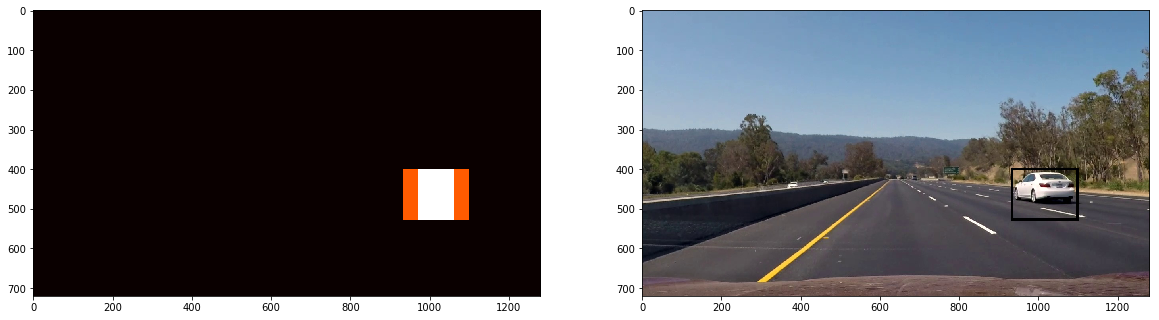

In [9]:
    
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img, box_list = draw_labeled_bboxes1(np.copy(image), labels)

print(' Found ', labels[1], ' cars in ', box_list)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(heatmap, cmap='hot')
plt.subplot(122)
plt.imshow(draw_img)



#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I used four scales and selected region of interest using 
YCrCb 3-channel 
HOG features on first channel 
spatially binned color (16,16)
histograms of color 

I focused on the right size of the image, to avoid car detection in th eopposite lane. I also searched in the bottom half of the image. I used 4 scales to increase heapmap value to 3 or 4 for the overlapping windows. I applied threshold of 3 to filter out false positives. There were few trouble spots where car wasnt detected, in that case, i applied threshold of 2 and minimized false positives. 

2 cells below shows testing of the pipeline. I converted original video into individual images and experiemnted pipeline on the several random images.


In [15]:
#((x1,y1), (x2,y2))
window_roi= [((900,400),(1280,700)), ((900,390),(1280,700)), ((700,400),(1280,700)), ((700,400),(1280,700)) ]
scale_list=[2.0, 1.5, 1.0, 1.25]

vehicle_count = 0

centroids_car1=[]
centroids_car2=[]

vehicle_tracker = {}
vehicle_count = 0

# load the saved model
svc = joblib.load(filename1)
X_scaler = joblib.load(filename2)

def pipeline(image, visualize=False):
    global vehicle_tracker, vehicle_count
    global n_count, prev_bboxes, heatmaps, heatmaps_avg_len,vehicle_detected
    
    if n_count%2 == 0:
        hot_windows = []

        #if len(images) <= images_avg_len :
        #    images.append(image)
        #else:
        #    images.pop(0)
        #    images.append(image)

        #image = np.mean(images, axis=0)

        for i, (roi, scale) in enumerate(zip(window_roi, scale_list)):
            if i == 1 :
                hot_windows = find_cars(image, roi[0][1], roi[1][1], roi[0][0], roi[1][0], scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, (spatial, spatial), hist_bins)
            else:
                hot_windows += find_cars(image, roi[0][1], roi[1][1], roi[0][0], roi[1][0], scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, (spatial, spatial), hist_bins)

        if visualize == True:
            window_img = draw_boxes(np.copy(image), hot_windows, color=(0, 255, 255), thick=4) 
            print('hot windows', hot_windows)

        heat = np.zeros_like(image[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        #heat = add_heat(heat,new_hot_windows)
        heat = add_heat(heat,hot_windows)


        if len(heatmaps) <= heatmaps_avg_len :
            heatmaps.append(heat)
        else:
            heatmaps.pop(0)
            heatmaps.append(heat)

        heat = np.mean(heatmaps, axis=0)

       # Apply threshold to help remove false positives
        heat = apply_threshold(heat,3)
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        print(labels[1])

        if labels[1] > 0 and vehicle_detected == False:
            vehicle_detected = True
            
        #if no car found, reduce threshold to 2
        if labels[1] == 0 and vehicle_detected == True :
            heat = apply_threshold(heat,1)
            heatmap = np.clip(heat, 0, 255)
            labels = label(heatmap)
            

        #draw_img, box_list = draw_labeled_bboxes(np.copy(image), labels, vehicle_tracker)
        draw_img, box_list = draw_labeled_bboxes2(np.copy(image), labels)
        
        prev_bboxes = box_list
        
        if visualize == True:
            for box, car in zip(box_list, range(labels[1])):
                print(' Found car # ', car+1, ' in ', box)


            f, axarr = plt.subplots(2, 2, figsize=(20,20))
            axarr[0,0].imshow(image)
            axarr[0,0].set_title('Original Image')
            axarr[0,1].imshow(window_img)
            axarr[0,1].set_title('Sliding windows')
            axarr[1,0].imshow(heatmap, cmap='hot')
            axarr[1,0].set_title('Heatmap')
            axarr[1,1].imshow(draw_img)
            axarr[1,1].set_title('Label bound box')
            plt.tight_layout()

    else:
        draw_img = draw_boxes(np.copy(image), prev_bboxes)
   
    n_count += 1
    
    if visualize:
        return draw_img, box_list
    else:
        return draw_img


## Testing pipeline

hot windows [((892, 400), (956, 464)), ((892, 416), (956, 480)), ((908, 416), (972, 480)), ((880, 400), (960, 480)), ((880, 420), (960, 500))]
1
 Found car #  1  in  ((892, 416), (959, 479))


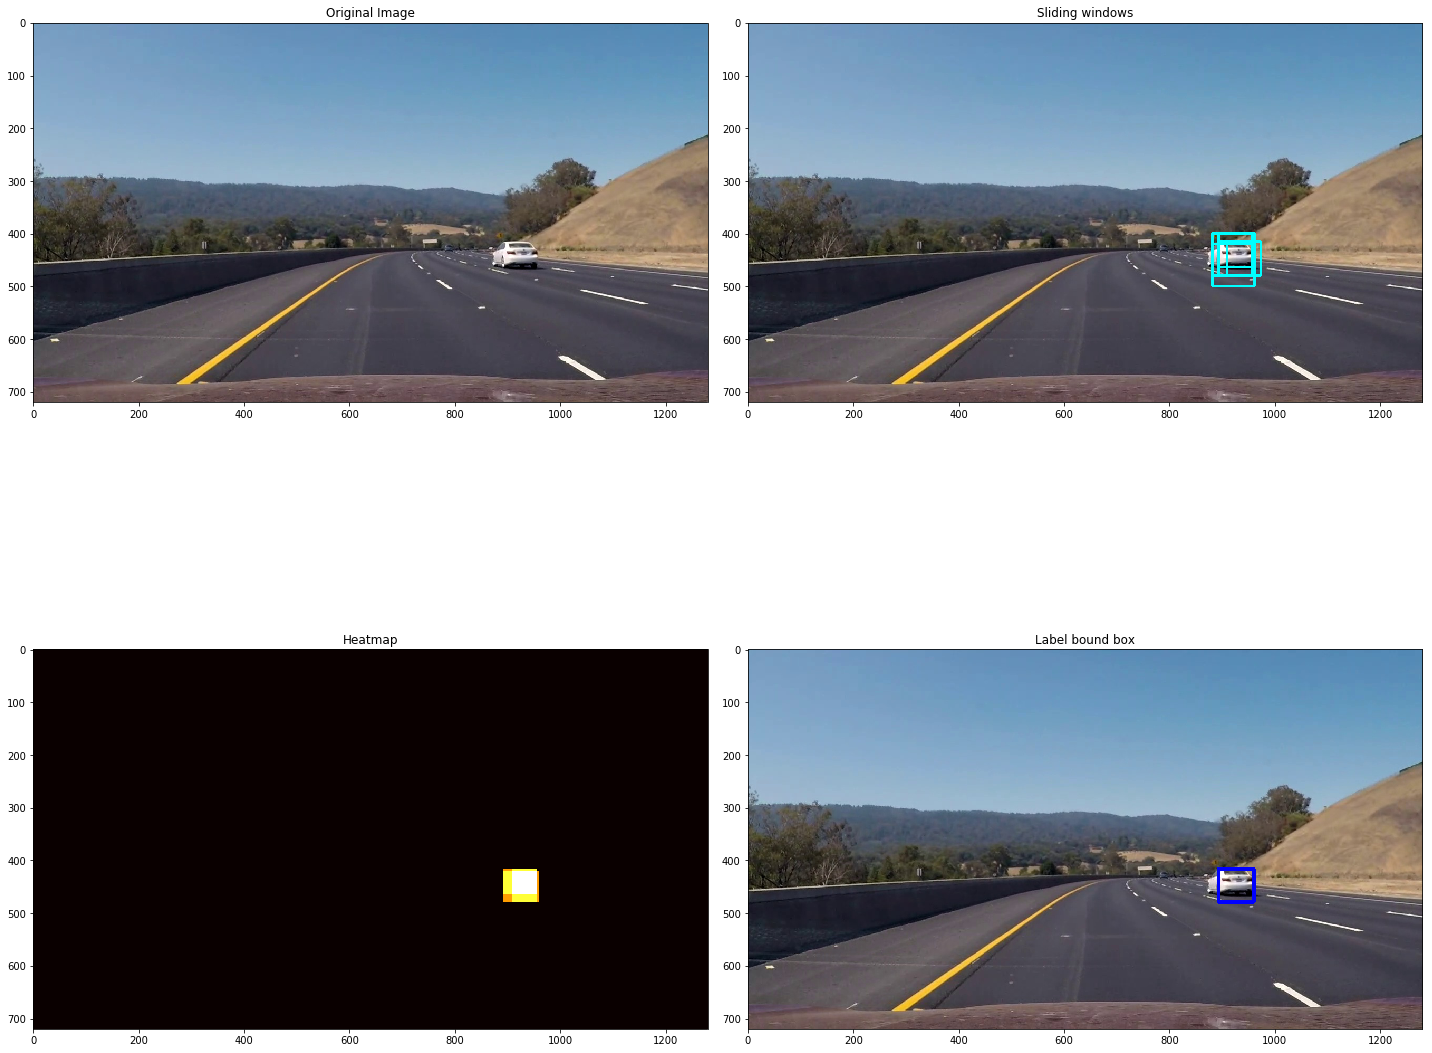

In [16]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = True


#Testing
#image = mpimg.imread('test_images/test5.jpg')
#image = mpimg.imread('video_images/frame298.jpg')
#image = mpimg.imread('video_images/frame416.jpg')
#image = mpimg.imread('video_images/frame577.jpg')
image = mpimg.imread('video_images/frame651.jpg')
#image = mpimg.imread('video_images/frame732.jpg')
#image = mpimg.imread('video_images/frame999.jpg')

output, box_list = pipeline(image, True)

#image = mpimg.imread('video_images/frame582.jpg')
#image = mpimg.imread('video_images/frame757.jpg')
#output, box_list = pipeline(image, True)

### Video Implementation


#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

here's a <a href="./project_video_output.mp4" >link</a> to the output video.

Windows were wobbly during the initial testing. I did two things to reduce the wobbliness.

1> used the counter to skip the odd number of frames as detection window didnt change much in a single frame.

2> I used average of heatmap from the last 5 frames.


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

To minimize the false positive, I did the following

1> I kept scales between 1.0 and 2.0  I also experimented with 0.75 scale but smaller window detected lot of false positive on the extreme right side and shades.

2> I used 4 scales. Reasoning was when there were lot of overlapping windows, when we applied heatmap, pixel value was increased to 3 or 4 value. False detective had generally pixel value of 1 or 2. So using threshold of 3, was able to minimize the false positive. 

3> I then used `scipy.ndimage.measurements.label()` to detect the car using the "avergae of last 5" heatmap. Label method provide tuple of image object and number of the object. Image object was used to determine min and max of x and y position of nonzero pixels, which provided the bound outline for the object detected ( which is car in this case). 

4> I used another constraint to reduce false positive, the difference between max and min X and Y should be greater than 62 pixels. There were few spots, where car wasnt detected, so I had to re-apply the threshold of 2 and redo the label method. 

5> I used counter and did searching for the cars in the even number of frames, to speed up the processing.

Note: I had one trouble spot, after the second bridge when both black and white car cross together, the shade of the tree caused detection video to become big and after few frames, it recovered.

scroll to the bottom for the continuation of the writeup.


In [11]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = False

video_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

0
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

0


  0%|▏                                                                                | 2/1261 [00:00<07:31,  2.79it/s]

0


  0%|▎                                                                                | 4/1261 [00:01<07:28,  2.81it/s]

0


  0%|▍                                                                                | 6/1261 [00:02<07:20,  2.85it/s]

0


  1%|▌                                                                                | 8/1261 [00:02<07:14,  2.88it/s]

0


  1%|▋                                                                               | 10/1261 [00:03<07:14,  2.88it/s]

0


  1%|▊                                                                               | 12/1261 [00:04<07:13,  2.88it/s]

0


  1%|▉                                                                               | 14/1261 [00:04<07:12,  2.88it/s]

0


  1%|█                                                                               | 16/1261 [00:05<07:17,  2.84it/s]

0


  1%|█▏                                                                              | 18/1261 [00:06<07:19,  2.83it/s]

0


  2%|█▎                                                                              | 20/1261 [00:07<07:22,  2.80it/s]

0


  2%|█▍                                                                              | 22/1261 [00:07<07:28,  2.76it/s]

0


  2%|█▌                                                                              | 24/1261 [00:08<07:40,  2.68it/s]

0


  2%|█▋                                                                              | 26/1261 [00:09<07:27,  2.76it/s]

0


  2%|█▊                                                                              | 28/1261 [00:09<07:17,  2.82it/s]

0


  2%|█▉                                                                              | 30/1261 [00:10<07:17,  2.81it/s]

0


  3%|██                                                                              | 32/1261 [00:11<07:15,  2.82it/s]

0


  3%|██▏                                                                             | 34/1261 [00:12<07:13,  2.83it/s]

0


  3%|██▎                                                                             | 36/1261 [00:12<07:10,  2.85it/s]

0


  3%|██▍                                                                             | 38/1261 [00:13<07:07,  2.86it/s]

0


  3%|██▌                                                                             | 40/1261 [00:14<07:05,  2.87it/s]

0


  3%|██▋                                                                             | 42/1261 [00:14<06:59,  2.90it/s]

0


  3%|██▊                                                                             | 44/1261 [00:15<06:59,  2.90it/s]

0


  4%|██▉                                                                             | 46/1261 [00:16<06:59,  2.89it/s]

0


  4%|███                                                                             | 48/1261 [00:16<07:02,  2.87it/s]

0


  4%|███▏                                                                            | 50/1261 [00:17<07:04,  2.85it/s]

0


  4%|███▎                                                                            | 52/1261 [00:18<07:04,  2.85it/s]

0


  4%|███▍                                                                            | 54/1261 [00:18<07:01,  2.86it/s]

0


  4%|███▌                                                                            | 56/1261 [00:19<07:02,  2.85it/s]

0


  5%|███▋                                                                            | 58/1261 [00:20<07:03,  2.84it/s]

0


  5%|███▊                                                                            | 60/1261 [00:21<07:06,  2.82it/s]

0


  5%|███▉                                                                            | 62/1261 [00:21<07:06,  2.81it/s]

0


  5%|████                                                                            | 64/1261 [00:22<07:05,  2.81it/s]

0


  5%|████▏                                                                           | 66/1261 [00:23<07:07,  2.80it/s]

0


  5%|████▎                                                                           | 68/1261 [00:23<07:06,  2.80it/s]

0


  6%|████▍                                                                           | 70/1261 [00:24<07:05,  2.80it/s]

0


  6%|████▌                                                                           | 72/1261 [00:25<07:07,  2.78it/s]

0


  6%|████▋                                                                           | 74/1261 [00:26<07:06,  2.78it/s]

0


  6%|████▊                                                                           | 76/1261 [00:26<07:04,  2.79it/s]

0


  6%|████▉                                                                           | 78/1261 [00:27<07:03,  2.79it/s]

0


  6%|█████                                                                           | 80/1261 [00:28<07:02,  2.80it/s]

0


  7%|█████▏                                                                          | 82/1261 [00:29<07:04,  2.78it/s]

0


  7%|█████▎                                                                          | 84/1261 [00:29<07:05,  2.77it/s]

0


  7%|█████▍                                                                          | 86/1261 [00:30<07:04,  2.77it/s]

0


  7%|█████▌                                                                          | 88/1261 [00:31<07:04,  2.76it/s]

0


  7%|█████▋                                                                          | 90/1261 [00:31<07:02,  2.77it/s]

0


  7%|█████▊                                                                          | 92/1261 [00:32<07:00,  2.78it/s]

0


  7%|█████▉                                                                          | 94/1261 [00:33<07:01,  2.77it/s]

0


  8%|██████                                                                          | 96/1261 [00:34<07:01,  2.77it/s]

0


  8%|██████▏                                                                         | 98/1261 [00:34<06:59,  2.77it/s]

0


  8%|██████▎                                                                        | 100/1261 [00:35<07:02,  2.75it/s]

0


  8%|██████▍                                                                        | 102/1261 [00:36<06:58,  2.77it/s]

0


  8%|██████▌                                                                        | 104/1261 [00:36<06:55,  2.78it/s]

0


  8%|██████▋                                                                        | 106/1261 [00:37<06:55,  2.78it/s]

0


  9%|██████▊                                                                        | 108/1261 [00:38<06:54,  2.78it/s]

0


  9%|██████▉                                                                        | 110/1261 [00:39<06:54,  2.78it/s]

0


  9%|███████                                                                        | 112/1261 [00:39<06:52,  2.79it/s]

0


  9%|███████▏                                                                       | 114/1261 [00:40<06:52,  2.78it/s]

0


  9%|███████▎                                                                       | 116/1261 [00:41<06:54,  2.76it/s]

0


  9%|███████▍                                                                       | 118/1261 [00:42<06:54,  2.76it/s]

0


 10%|███████▌                                                                       | 120/1261 [00:42<06:56,  2.74it/s]

0


 10%|███████▋                                                                       | 122/1261 [00:43<06:57,  2.73it/s]

0


 10%|███████▊                                                                       | 124/1261 [00:44<06:55,  2.74it/s]

0


 10%|███████▉                                                                       | 126/1261 [00:44<06:58,  2.72it/s]

0


 10%|████████                                                                       | 128/1261 [00:45<06:56,  2.72it/s]

0


 10%|████████▏                                                                      | 130/1261 [00:46<06:54,  2.73it/s]

0


 10%|████████▎                                                                      | 132/1261 [00:47<06:49,  2.76it/s]

0


 11%|████████▍                                                                      | 134/1261 [00:47<06:51,  2.74it/s]

0


 11%|████████▌                                                                      | 136/1261 [00:48<06:50,  2.74it/s]

0


 11%|████████▋                                                                      | 138/1261 [00:49<06:51,  2.73it/s]

0


 11%|████████▊                                                                      | 140/1261 [00:50<06:47,  2.75it/s]

0


 11%|████████▉                                                                      | 142/1261 [00:50<06:55,  2.69it/s]

1


 11%|█████████                                                                      | 144/1261 [00:51<06:56,  2.68it/s]

1


 12%|█████████▏                                                                     | 146/1261 [00:52<06:59,  2.66it/s]

1


 12%|█████████▎                                                                     | 148/1261 [00:53<06:57,  2.67it/s]

1


 12%|█████████▍                                                                     | 150/1261 [00:53<06:53,  2.69it/s]

1


 12%|█████████▌                                                                     | 152/1261 [00:54<06:51,  2.70it/s]

1


 12%|█████████▋                                                                     | 154/1261 [00:55<06:47,  2.72it/s]

1


 12%|█████████▊                                                                     | 156/1261 [00:56<06:43,  2.74it/s]

1


 13%|█████████▉                                                                     | 158/1261 [00:56<06:39,  2.76it/s]

1


 13%|██████████                                                                     | 160/1261 [00:57<06:38,  2.76it/s]

1


 13%|██████████▏                                                                    | 162/1261 [00:58<06:41,  2.74it/s]

1


 13%|██████████▎                                                                    | 164/1261 [00:58<06:38,  2.75it/s]

1


 13%|██████████▍                                                                    | 166/1261 [00:59<06:38,  2.75it/s]

1


 13%|██████████▌                                                                    | 168/1261 [01:00<06:39,  2.74it/s]

1


 13%|██████████▋                                                                    | 170/1261 [01:01<06:39,  2.73it/s]

1


 14%|██████████▊                                                                    | 172/1261 [01:01<06:35,  2.75it/s]

1


 14%|██████████▉                                                                    | 174/1261 [01:02<06:32,  2.77it/s]

1


 14%|███████████                                                                    | 176/1261 [01:03<06:33,  2.76it/s]

1


 14%|███████████▏                                                                   | 178/1261 [01:04<06:34,  2.75it/s]

1


 14%|███████████▎                                                                   | 180/1261 [01:04<06:35,  2.73it/s]

1


 14%|███████████▍                                                                   | 182/1261 [01:05<06:35,  2.73it/s]

1


 15%|███████████▌                                                                   | 184/1261 [01:06<06:33,  2.73it/s]

1


 15%|███████████▋                                                                   | 186/1261 [01:06<06:36,  2.71it/s]

1


 15%|███████████▊                                                                   | 188/1261 [01:07<06:34,  2.72it/s]

1


 15%|███████████▉                                                                   | 190/1261 [01:08<06:34,  2.71it/s]

1


 15%|████████████                                                                   | 192/1261 [01:09<06:31,  2.73it/s]

1


 15%|████████████▏                                                                  | 194/1261 [01:09<06:33,  2.71it/s]

1


 16%|████████████▎                                                                  | 196/1261 [01:10<06:34,  2.70it/s]

1


 16%|████████████▍                                                                  | 198/1261 [01:11<06:32,  2.71it/s]

1


 16%|████████████▌                                                                  | 200/1261 [01:12<06:27,  2.74it/s]

1


 16%|████████████▋                                                                  | 202/1261 [01:12<06:29,  2.72it/s]

1


 16%|████████████▊                                                                  | 204/1261 [01:13<06:26,  2.73it/s]

1


 16%|████████████▉                                                                  | 206/1261 [01:14<06:25,  2.74it/s]

1


 16%|█████████████                                                                  | 208/1261 [01:15<06:22,  2.76it/s]

1


 17%|█████████████▏                                                                 | 210/1261 [01:15<06:22,  2.75it/s]

1


 17%|█████████████▎                                                                 | 212/1261 [01:16<06:24,  2.73it/s]

1


 17%|█████████████▍                                                                 | 214/1261 [01:17<06:22,  2.74it/s]

1


 17%|█████████████▌                                                                 | 216/1261 [01:17<06:25,  2.71it/s]

1


 17%|█████████████▋                                                                 | 218/1261 [01:18<06:23,  2.72it/s]

1


 17%|█████████████▊                                                                 | 220/1261 [01:19<06:21,  2.73it/s]

1


 18%|█████████████▉                                                                 | 222/1261 [01:20<06:20,  2.73it/s]

1


 18%|██████████████                                                                 | 224/1261 [01:20<06:22,  2.71it/s]

1


 18%|██████████████▏                                                                | 226/1261 [01:21<06:20,  2.72it/s]

1


 18%|██████████████▎                                                                | 228/1261 [01:22<06:22,  2.70it/s]

1


 18%|██████████████▍                                                                | 230/1261 [01:23<06:23,  2.69it/s]

1


 18%|██████████████▌                                                                | 232/1261 [01:23<06:23,  2.68it/s]

1


 19%|██████████████▋                                                                | 234/1261 [01:24<06:24,  2.67it/s]

1


 19%|██████████████▊                                                                | 236/1261 [01:25<06:24,  2.67it/s]

1


 19%|██████████████▉                                                                | 238/1261 [01:26<06:23,  2.67it/s]

1


 19%|███████████████                                                                | 240/1261 [01:26<06:22,  2.67it/s]

1


 19%|███████████████▏                                                               | 242/1261 [01:27<06:21,  2.67it/s]

1


 19%|███████████████▎                                                               | 244/1261 [01:28<06:19,  2.68it/s]

1


 20%|███████████████▍                                                               | 246/1261 [01:29<06:16,  2.70it/s]

1


 20%|███████████████▌                                                               | 248/1261 [01:29<06:19,  2.67it/s]

1


 20%|███████████████▋                                                               | 250/1261 [01:30<06:16,  2.69it/s]

1


 20%|███████████████▊                                                               | 252/1261 [01:31<06:28,  2.60it/s]

1


 20%|███████████████▉                                                               | 254/1261 [01:32<06:27,  2.60it/s]

1


 20%|████████████████                                                               | 256/1261 [01:32<06:19,  2.65it/s]

1


 20%|████████████████▏                                                              | 258/1261 [01:33<06:15,  2.67it/s]

1


 21%|████████████████▎                                                              | 260/1261 [01:34<06:12,  2.69it/s]

1


 21%|████████████████▍                                                              | 262/1261 [01:35<06:10,  2.70it/s]

1


 21%|████████████████▌                                                              | 264/1261 [01:35<06:07,  2.71it/s]

1


 21%|████████████████▋                                                              | 266/1261 [01:36<06:09,  2.69it/s]

1


 21%|████████████████▊                                                              | 268/1261 [01:37<06:08,  2.69it/s]

1


 21%|████████████████▉                                                              | 270/1261 [01:38<06:07,  2.69it/s]

1


 22%|█████████████████                                                              | 272/1261 [01:38<06:02,  2.73it/s]

1


 22%|█████████████████▏                                                             | 274/1261 [01:39<06:04,  2.71it/s]

1


 22%|█████████████████▎                                                             | 276/1261 [01:40<06:04,  2.71it/s]

1


 22%|█████████████████▍                                                             | 278/1261 [01:41<06:00,  2.72it/s]

1


 22%|█████████████████▌                                                             | 280/1261 [01:41<06:02,  2.71it/s]

1


 22%|█████████████████▋                                                             | 282/1261 [01:42<05:59,  2.72it/s]

1


 23%|█████████████████▊                                                             | 284/1261 [01:43<05:55,  2.75it/s]

1


 23%|█████████████████▉                                                             | 286/1261 [01:43<05:52,  2.76it/s]

1


 23%|██████████████████                                                             | 288/1261 [01:44<05:55,  2.73it/s]

1


 23%|██████████████████▏                                                            | 290/1261 [01:45<05:57,  2.72it/s]

1


 23%|██████████████████▎                                                            | 292/1261 [01:46<05:54,  2.73it/s]

1


 23%|██████████████████▍                                                            | 294/1261 [01:46<05:52,  2.74it/s]

1


 23%|██████████████████▌                                                            | 296/1261 [01:47<05:54,  2.72it/s]

1


 24%|██████████████████▋                                                            | 298/1261 [01:48<05:52,  2.73it/s]

1


 24%|██████████████████▊                                                            | 300/1261 [01:49<05:54,  2.71it/s]

1


 24%|██████████████████▉                                                            | 302/1261 [01:49<05:51,  2.73it/s]

1


 24%|███████████████████                                                            | 304/1261 [01:50<05:52,  2.71it/s]

1


 24%|███████████████████▏                                                           | 306/1261 [01:51<05:52,  2.71it/s]

1


 24%|███████████████████▎                                                           | 308/1261 [01:52<05:53,  2.69it/s]

1


 25%|███████████████████▍                                                           | 310/1261 [01:52<05:56,  2.67it/s]

1


 25%|███████████████████▌                                                           | 312/1261 [01:53<05:55,  2.67it/s]

1


 25%|███████████████████▋                                                           | 314/1261 [01:54<05:54,  2.67it/s]

1


 25%|███████████████████▊                                                           | 316/1261 [01:55<05:51,  2.69it/s]

1


 25%|███████████████████▉                                                           | 318/1261 [01:55<05:52,  2.68it/s]

1


 25%|████████████████████                                                           | 320/1261 [01:56<05:48,  2.70it/s]

1


 26%|████████████████████▏                                                          | 322/1261 [01:57<05:46,  2.71it/s]

1


 26%|████████████████████▎                                                          | 324/1261 [01:58<05:43,  2.73it/s]

1


 26%|████████████████████▍                                                          | 326/1261 [01:58<05:44,  2.71it/s]

1


 26%|████████████████████▌                                                          | 328/1261 [01:59<05:42,  2.72it/s]

1


 26%|████████████████████▋                                                          | 330/1261 [02:00<05:42,  2.72it/s]

1


 26%|████████████████████▊                                                          | 332/1261 [02:00<05:44,  2.69it/s]

1


 26%|████████████████████▉                                                          | 334/1261 [02:01<05:44,  2.69it/s]

1


 27%|█████████████████████                                                          | 336/1261 [02:02<05:43,  2.69it/s]

1


 27%|█████████████████████▏                                                         | 338/1261 [02:03<05:43,  2.68it/s]

1


 27%|█████████████████████▎                                                         | 340/1261 [02:03<05:43,  2.68it/s]

1


 27%|█████████████████████▍                                                         | 342/1261 [02:04<05:43,  2.67it/s]

1


 27%|█████████████████████▌                                                         | 344/1261 [02:05<05:46,  2.65it/s]

1


 27%|█████████████████████▋                                                         | 346/1261 [02:06<05:41,  2.68it/s]

1


 28%|█████████████████████▊                                                         | 348/1261 [02:06<05:39,  2.69it/s]

1


 28%|█████████████████████▉                                                         | 350/1261 [02:07<05:36,  2.71it/s]

1


 28%|██████████████████████                                                         | 352/1261 [02:08<05:33,  2.72it/s]

1


 28%|██████████████████████▏                                                        | 354/1261 [02:09<05:31,  2.74it/s]

2


 28%|██████████████████████▎                                                        | 356/1261 [02:09<05:35,  2.70it/s]

1


 28%|██████████████████████▍                                                        | 358/1261 [02:10<05:35,  2.69it/s]

1


 29%|██████████████████████▌                                                        | 360/1261 [02:11<05:32,  2.71it/s]

1


 29%|██████████████████████▋                                                        | 362/1261 [02:12<05:30,  2.72it/s]

1


 29%|██████████████████████▊                                                        | 364/1261 [02:12<05:31,  2.70it/s]

1


 29%|██████████████████████▉                                                        | 366/1261 [02:13<05:30,  2.70it/s]

1


 29%|███████████████████████                                                        | 368/1261 [02:14<05:31,  2.70it/s]

1


 29%|███████████████████████▏                                                       | 370/1261 [02:15<05:31,  2.69it/s]

2


 30%|███████████████████████▎                                                       | 372/1261 [02:15<05:31,  2.68it/s]

2


 30%|███████████████████████▍                                                       | 374/1261 [02:16<05:30,  2.68it/s]

2


 30%|███████████████████████▌                                                       | 376/1261 [02:17<05:31,  2.67it/s]

1


 30%|███████████████████████▋                                                       | 378/1261 [02:18<05:30,  2.67it/s]

1


 30%|███████████████████████▊                                                       | 380/1261 [02:18<05:30,  2.67it/s]

1


 30%|███████████████████████▉                                                       | 382/1261 [02:19<05:30,  2.66it/s]

1


 30%|████████████████████████                                                       | 384/1261 [02:20<05:28,  2.67it/s]

1


 31%|████████████████████████▏                                                      | 386/1261 [02:21<05:26,  2.68it/s]

2


 31%|████████████████████████▎                                                      | 388/1261 [02:21<05:24,  2.69it/s]

2


 31%|████████████████████████▍                                                      | 390/1261 [02:22<05:26,  2.67it/s]

1


 31%|████████████████████████▌                                                      | 392/1261 [02:23<05:25,  2.67it/s]

1


 31%|████████████████████████▋                                                      | 394/1261 [02:24<05:23,  2.68it/s]

1


 31%|████████████████████████▊                                                      | 396/1261 [02:24<05:22,  2.69it/s]

1


 32%|████████████████████████▉                                                      | 398/1261 [02:25<05:21,  2.68it/s]

1


 32%|█████████████████████████                                                      | 400/1261 [02:26<05:20,  2.68it/s]

1


 32%|█████████████████████████▏                                                     | 402/1261 [02:26<05:14,  2.73it/s]

1


 32%|█████████████████████████▎                                                     | 404/1261 [02:27<05:17,  2.70it/s]

1


 32%|█████████████████████████▍                                                     | 406/1261 [02:28<05:14,  2.72it/s]

1


 32%|█████████████████████████▌                                                     | 408/1261 [02:29<05:16,  2.70it/s]

1


 33%|█████████████████████████▋                                                     | 410/1261 [02:29<05:15,  2.70it/s]

1


 33%|█████████████████████████▊                                                     | 412/1261 [02:30<05:10,  2.73it/s]

1


 33%|█████████████████████████▉                                                     | 414/1261 [02:31<05:12,  2.71it/s]

1


 33%|██████████████████████████                                                     | 416/1261 [02:32<05:08,  2.74it/s]

1


 33%|██████████████████████████▏                                                    | 418/1261 [02:32<05:10,  2.72it/s]

1


 33%|██████████████████████████▎                                                    | 420/1261 [02:33<05:12,  2.69it/s]

1


 33%|██████████████████████████▍                                                    | 422/1261 [02:34<05:14,  2.67it/s]

1


 34%|██████████████████████████▌                                                    | 424/1261 [02:35<05:09,  2.71it/s]

1


 34%|██████████████████████████▋                                                    | 426/1261 [02:35<05:04,  2.74it/s]

1


 34%|██████████████████████████▊                                                    | 428/1261 [02:36<05:08,  2.70it/s]

1


 34%|██████████████████████████▉                                                    | 430/1261 [02:37<05:09,  2.69it/s]

1


 34%|███████████████████████████                                                    | 432/1261 [02:38<05:09,  2.67it/s]

1


 34%|███████████████████████████▏                                                   | 434/1261 [02:38<05:06,  2.69it/s]

1


 35%|███████████████████████████▎                                                   | 436/1261 [02:39<05:07,  2.69it/s]

1


 35%|███████████████████████████▍                                                   | 438/1261 [02:40<05:08,  2.67it/s]

1


 35%|███████████████████████████▌                                                   | 440/1261 [02:41<05:08,  2.66it/s]

1


 35%|███████████████████████████▋                                                   | 442/1261 [02:41<05:08,  2.66it/s]

1


 35%|███████████████████████████▊                                                   | 444/1261 [02:42<05:06,  2.66it/s]

1


 35%|███████████████████████████▉                                                   | 446/1261 [02:43<05:03,  2.69it/s]

1


 36%|████████████████████████████                                                   | 448/1261 [02:44<05:03,  2.68it/s]

1


 36%|████████████████████████████▏                                                  | 450/1261 [02:44<05:01,  2.69it/s]

1


 36%|████████████████████████████▎                                                  | 452/1261 [02:45<05:00,  2.69it/s]

1


 36%|████████████████████████████▍                                                  | 454/1261 [02:46<05:01,  2.67it/s]

1


 36%|████████████████████████████▌                                                  | 456/1261 [02:47<04:59,  2.69it/s]

1


 36%|████████████████████████████▋                                                  | 458/1261 [02:47<04:59,  2.68it/s]

1


 36%|████████████████████████████▊                                                  | 460/1261 [02:48<04:56,  2.70it/s]

1


 37%|████████████████████████████▉                                                  | 462/1261 [02:49<04:53,  2.72it/s]

1


 37%|█████████████████████████████                                                  | 464/1261 [02:50<04:53,  2.72it/s]

1


 37%|█████████████████████████████▏                                                 | 466/1261 [02:50<05:00,  2.65it/s]

1


 37%|█████████████████████████████▎                                                 | 468/1261 [02:51<05:01,  2.63it/s]

1


 37%|█████████████████████████████▍                                                 | 470/1261 [02:52<05:01,  2.62it/s]

1


 37%|█████████████████████████████▌                                                 | 472/1261 [02:53<04:54,  2.68it/s]

1


 38%|█████████████████████████████▋                                                 | 474/1261 [02:53<04:56,  2.65it/s]

1


 38%|█████████████████████████████▊                                                 | 476/1261 [02:54<04:53,  2.67it/s]

1


 38%|█████████████████████████████▉                                                 | 478/1261 [02:55<04:49,  2.70it/s]

1


 38%|██████████████████████████████                                                 | 480/1261 [02:56<04:49,  2.69it/s]

1


 38%|██████████████████████████████▏                                                | 482/1261 [02:56<04:45,  2.73it/s]

1


 38%|██████████████████████████████▎                                                | 484/1261 [02:57<04:45,  2.72it/s]

1


 39%|██████████████████████████████▍                                                | 486/1261 [02:58<04:44,  2.73it/s]

1


 39%|██████████████████████████████▌                                                | 488/1261 [02:58<04:43,  2.73it/s]

1


 39%|██████████████████████████████▋                                                | 490/1261 [02:59<04:45,  2.70it/s]

1


 39%|██████████████████████████████▊                                                | 492/1261 [03:00<04:45,  2.70it/s]

1


 39%|██████████████████████████████▉                                                | 494/1261 [03:01<04:48,  2.66it/s]

1


 39%|███████████████████████████████                                                | 496/1261 [03:01<04:48,  2.65it/s]

1


 39%|███████████████████████████████▏                                               | 498/1261 [03:02<04:47,  2.65it/s]

1


 40%|███████████████████████████████▎                                               | 500/1261 [03:03<04:45,  2.66it/s]

1


 40%|███████████████████████████████▍                                               | 502/1261 [03:04<04:42,  2.68it/s]

1


 40%|███████████████████████████████▌                                               | 504/1261 [03:04<04:40,  2.69it/s]

1


 40%|███████████████████████████████▋                                               | 506/1261 [03:05<04:40,  2.69it/s]

1


 40%|███████████████████████████████▊                                               | 508/1261 [03:06<04:39,  2.70it/s]

1


 40%|███████████████████████████████▉                                               | 510/1261 [03:07<04:40,  2.68it/s]

1


 41%|████████████████████████████████                                               | 512/1261 [03:07<04:41,  2.66it/s]

1


 41%|████████████████████████████████▏                                              | 514/1261 [03:08<04:41,  2.66it/s]

1


 41%|████████████████████████████████▎                                              | 516/1261 [03:09<04:39,  2.67it/s]

1


 41%|████████████████████████████████▍                                              | 518/1261 [03:10<04:38,  2.67it/s]

1


 41%|████████████████████████████████▌                                              | 520/1261 [03:10<04:37,  2.67it/s]

1


 41%|████████████████████████████████▋                                              | 522/1261 [03:11<04:33,  2.71it/s]

1


 42%|████████████████████████████████▊                                              | 524/1261 [03:12<04:28,  2.74it/s]

1


 42%|████████████████████████████████▉                                              | 526/1261 [03:13<04:28,  2.74it/s]

1


 42%|█████████████████████████████████                                              | 528/1261 [03:13<04:28,  2.73it/s]

1


 42%|█████████████████████████████████▏                                             | 530/1261 [03:14<04:29,  2.71it/s]

1


 42%|█████████████████████████████████▎                                             | 532/1261 [03:15<04:37,  2.63it/s]

1


 42%|█████████████████████████████████▍                                             | 534/1261 [03:16<04:35,  2.64it/s]

1


 43%|█████████████████████████████████▌                                             | 536/1261 [03:16<04:34,  2.64it/s]

1


 43%|█████████████████████████████████▋                                             | 538/1261 [03:17<04:31,  2.67it/s]

1


 43%|█████████████████████████████████▊                                             | 540/1261 [03:18<04:28,  2.69it/s]

1


 43%|█████████████████████████████████▉                                             | 542/1261 [03:19<04:26,  2.70it/s]

1


 43%|██████████████████████████████████                                             | 544/1261 [03:19<04:25,  2.70it/s]

1


 43%|██████████████████████████████████▏                                            | 546/1261 [03:20<04:25,  2.69it/s]

1


 43%|██████████████████████████████████▎                                            | 548/1261 [03:21<04:23,  2.70it/s]

1


 44%|██████████████████████████████████▍                                            | 550/1261 [03:22<04:25,  2.68it/s]

1


 44%|██████████████████████████████████▌                                            | 552/1261 [03:22<04:29,  2.63it/s]

1


 44%|██████████████████████████████████▋                                            | 554/1261 [03:23<04:32,  2.60it/s]

1


 44%|██████████████████████████████████▊                                            | 556/1261 [03:24<04:32,  2.59it/s]

1


 44%|██████████████████████████████████▉                                            | 558/1261 [03:25<04:34,  2.57it/s]

1


 44%|███████████████████████████████████                                            | 560/1261 [03:26<04:32,  2.57it/s]

1


 45%|███████████████████████████████████▏                                           | 562/1261 [03:26<04:30,  2.59it/s]

1


 45%|███████████████████████████████████▎                                           | 564/1261 [03:27<04:29,  2.59it/s]

1


 45%|███████████████████████████████████▍                                           | 566/1261 [03:28<04:28,  2.59it/s]

1


 45%|███████████████████████████████████▌                                           | 568/1261 [03:29<04:29,  2.57it/s]

1


 45%|███████████████████████████████████▋                                           | 570/1261 [03:29<04:28,  2.57it/s]

1


 45%|███████████████████████████████████▊                                           | 572/1261 [03:30<04:30,  2.55it/s]

1


 46%|███████████████████████████████████▉                                           | 574/1261 [03:31<04:30,  2.54it/s]

1


 46%|████████████████████████████████████                                           | 576/1261 [03:32<04:30,  2.53it/s]

1


 46%|████████████████████████████████████▏                                          | 578/1261 [03:33<04:29,  2.53it/s]

1


 46%|████████████████████████████████████▎                                          | 580/1261 [03:33<04:25,  2.56it/s]

1


 46%|████████████████████████████████████▍                                          | 582/1261 [03:34<04:24,  2.57it/s]

1


 46%|████████████████████████████████████▌                                          | 584/1261 [03:35<04:21,  2.59it/s]

1


 46%|████████████████████████████████████▋                                          | 586/1261 [03:36<04:22,  2.57it/s]

1


 47%|████████████████████████████████████▊                                          | 588/1261 [03:36<04:23,  2.55it/s]

1


 47%|████████████████████████████████████▉                                          | 590/1261 [03:37<04:24,  2.53it/s]

1


 47%|█████████████████████████████████████                                          | 592/1261 [03:38<04:20,  2.56it/s]

1


 47%|█████████████████████████████████████▏                                         | 594/1261 [03:39<04:20,  2.56it/s]

1


 47%|█████████████████████████████████████▎                                         | 596/1261 [03:40<04:20,  2.56it/s]

1


 47%|█████████████████████████████████████▍                                         | 598/1261 [03:40<04:20,  2.54it/s]

1


 48%|█████████████████████████████████████▌                                         | 600/1261 [03:41<04:20,  2.54it/s]

1


 48%|█████████████████████████████████████▋                                         | 602/1261 [03:42<04:19,  2.54it/s]

1


 48%|█████████████████████████████████████▊                                         | 604/1261 [03:43<04:19,  2.54it/s]

1


 48%|█████████████████████████████████████▉                                         | 606/1261 [03:44<04:21,  2.51it/s]

1


 48%|██████████████████████████████████████                                         | 608/1261 [03:44<04:20,  2.50it/s]

1


 48%|██████████████████████████████████████▏                                        | 610/1261 [03:45<04:17,  2.53it/s]

1


 49%|██████████████████████████████████████▎                                        | 612/1261 [03:46<04:13,  2.56it/s]

1


 49%|██████████████████████████████████████▍                                        | 614/1261 [03:47<04:10,  2.58it/s]

1


 49%|██████████████████████████████████████▌                                        | 616/1261 [03:47<04:04,  2.64it/s]

1


 49%|██████████████████████████████████████▋                                        | 618/1261 [03:48<04:05,  2.61it/s]

2


 49%|██████████████████████████████████████▊                                        | 620/1261 [03:49<04:00,  2.66it/s]

2


 49%|██████████████████████████████████████▉                                        | 622/1261 [03:50<04:02,  2.63it/s]

2


 49%|███████████████████████████████████████                                        | 624/1261 [03:50<04:02,  2.63it/s]

2


 50%|███████████████████████████████████████▏                                       | 626/1261 [03:51<04:02,  2.62it/s]

1


 50%|███████████████████████████████████████▎                                       | 628/1261 [03:52<04:01,  2.62it/s]

1


 50%|███████████████████████████████████████▍                                       | 630/1261 [03:53<03:57,  2.65it/s]

1


 50%|███████████████████████████████████████▌                                       | 632/1261 [03:53<03:58,  2.64it/s]

1


 50%|███████████████████████████████████████▋                                       | 634/1261 [03:54<03:58,  2.63it/s]

1


 50%|███████████████████████████████████████▊                                       | 636/1261 [03:55<03:57,  2.63it/s]

1


 51%|███████████████████████████████████████▉                                       | 638/1261 [03:56<03:56,  2.63it/s]

1


 51%|████████████████████████████████████████                                       | 640/1261 [03:57<03:55,  2.64it/s]

1


 51%|████████████████████████████████████████▏                                      | 642/1261 [03:57<03:51,  2.68it/s]

1


 51%|████████████████████████████████████████▎                                      | 644/1261 [03:58<03:50,  2.67it/s]

1


 51%|████████████████████████████████████████▍                                      | 646/1261 [03:59<03:52,  2.65it/s]

1


 51%|████████████████████████████████████████▌                                      | 648/1261 [04:00<03:52,  2.63it/s]

1


 52%|████████████████████████████████████████▋                                      | 650/1261 [04:00<03:50,  2.65it/s]

1


 52%|████████████████████████████████████████▊                                      | 652/1261 [04:01<03:51,  2.63it/s]

1


 52%|████████████████████████████████████████▉                                      | 654/1261 [04:02<03:50,  2.64it/s]

1


 52%|█████████████████████████████████████████                                      | 656/1261 [04:03<03:48,  2.65it/s]

1


 52%|█████████████████████████████████████████▏                                     | 658/1261 [04:03<03:58,  2.53it/s]

1


 52%|█████████████████████████████████████████▎                                     | 660/1261 [04:04<04:05,  2.44it/s]

1


 52%|█████████████████████████████████████████▍                                     | 662/1261 [04:05<04:01,  2.48it/s]

1


 53%|█████████████████████████████████████████▌                                     | 664/1261 [04:06<03:55,  2.54it/s]

1


 53%|█████████████████████████████████████████▋                                     | 666/1261 [04:07<03:51,  2.57it/s]

1


 53%|█████████████████████████████████████████▊                                     | 668/1261 [04:07<03:47,  2.61it/s]

1


 53%|█████████████████████████████████████████▉                                     | 670/1261 [04:08<03:46,  2.61it/s]

1


 53%|██████████████████████████████████████████                                     | 672/1261 [04:09<04:02,  2.42it/s]

1


 53%|██████████████████████████████████████████▏                                    | 674/1261 [04:10<03:55,  2.49it/s]

1


 54%|██████████████████████████████████████████▎                                    | 676/1261 [04:11<03:49,  2.55it/s]

1


 54%|██████████████████████████████████████████▍                                    | 678/1261 [04:11<03:46,  2.57it/s]

1


 54%|██████████████████████████████████████████▌                                    | 680/1261 [04:12<03:42,  2.61it/s]

1


 54%|██████████████████████████████████████████▋                                    | 682/1261 [04:13<03:40,  2.63it/s]

1


 54%|██████████████████████████████████████████▊                                    | 684/1261 [04:14<03:40,  2.61it/s]

1


 54%|██████████████████████████████████████████▉                                    | 686/1261 [04:14<03:38,  2.63it/s]

1


 55%|███████████████████████████████████████████                                    | 688/1261 [04:15<03:37,  2.64it/s]

1


 55%|███████████████████████████████████████████▏                                   | 690/1261 [04:16<03:36,  2.64it/s]

2


 55%|███████████████████████████████████████████▎                                   | 692/1261 [04:17<03:36,  2.63it/s]

2


 55%|███████████████████████████████████████████▍                                   | 694/1261 [04:17<03:36,  2.62it/s]

2


 55%|███████████████████████████████████████████▌                                   | 696/1261 [04:18<03:36,  2.61it/s]

2


 55%|███████████████████████████████████████████▋                                   | 698/1261 [04:19<03:35,  2.61it/s]

2


 56%|███████████████████████████████████████████▊                                   | 700/1261 [04:20<03:34,  2.61it/s]

2


 56%|███████████████████████████████████████████▉                                   | 702/1261 [04:20<03:34,  2.61it/s]

2


 56%|████████████████████████████████████████████                                   | 704/1261 [04:21<03:31,  2.63it/s]

2


 56%|████████████████████████████████████████████▏                                  | 706/1261 [04:22<03:31,  2.63it/s]

2


 56%|████████████████████████████████████████████▎                                  | 708/1261 [04:23<03:31,  2.62it/s]

2


 56%|████████████████████████████████████████████▍                                  | 710/1261 [04:24<03:40,  2.50it/s]

3


 56%|████████████████████████████████████████████▌                                  | 712/1261 [04:24<03:39,  2.50it/s]

3


 57%|████████████████████████████████████████████▋                                  | 714/1261 [04:25<03:37,  2.51it/s]

3


 57%|████████████████████████████████████████████▊                                  | 716/1261 [04:26<03:37,  2.50it/s]

3


 57%|████████████████████████████████████████████▉                                  | 718/1261 [04:27<03:42,  2.44it/s]

3


 57%|█████████████████████████████████████████████                                  | 720/1261 [04:28<03:46,  2.38it/s]

2


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [04:29<03:46,  2.38it/s]

2


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [04:29<03:47,  2.36it/s]

2


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [04:30<03:52,  2.30it/s]

2


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [04:31<03:55,  2.27it/s]

2


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [04:32<03:52,  2.28it/s]

2


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [04:33<03:48,  2.31it/s]

2


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [04:34<03:47,  2.32it/s]

2


 58%|██████████████████████████████████████████████                                 | 736/1261 [04:35<03:46,  2.31it/s]

2


 59%|██████████████████████████████████████████████▏                                | 738/1261 [04:36<03:45,  2.32it/s]

2


 59%|██████████████████████████████████████████████▎                                | 740/1261 [04:36<03:43,  2.34it/s]

2


 59%|██████████████████████████████████████████████▍                                | 742/1261 [04:37<03:41,  2.35it/s]

2


 59%|██████████████████████████████████████████████▌                                | 744/1261 [04:38<03:38,  2.37it/s]

2


 59%|██████████████████████████████████████████████▋                                | 746/1261 [04:39<03:35,  2.39it/s]

2


 59%|██████████████████████████████████████████████▊                                | 748/1261 [04:40<03:30,  2.43it/s]

2


 59%|██████████████████████████████████████████████▉                                | 750/1261 [04:40<03:25,  2.48it/s]

1


 60%|███████████████████████████████████████████████                                | 752/1261 [04:41<03:21,  2.52it/s]

1


 60%|███████████████████████████████████████████████▏                               | 754/1261 [04:42<03:17,  2.57it/s]

1


 60%|███████████████████████████████████████████████▎                               | 756/1261 [04:43<03:19,  2.54it/s]

1


 60%|███████████████████████████████████████████████▍                               | 758/1261 [04:44<03:30,  2.39it/s]

1


 60%|███████████████████████████████████████████████▌                               | 760/1261 [04:45<03:29,  2.40it/s]

1


 60%|███████████████████████████████████████████████▋                               | 762/1261 [04:45<03:21,  2.47it/s]

1


 61%|███████████████████████████████████████████████▊                               | 764/1261 [04:46<03:18,  2.50it/s]

1


 61%|███████████████████████████████████████████████▉                               | 766/1261 [04:47<03:14,  2.54it/s]

1


 61%|████████████████████████████████████████████████                               | 768/1261 [04:48<03:12,  2.56it/s]

1


 61%|████████████████████████████████████████████████▏                              | 770/1261 [04:48<03:07,  2.62it/s]

1


 61%|████████████████████████████████████████████████▎                              | 772/1261 [04:49<03:06,  2.62it/s]

1


 61%|████████████████████████████████████████████████▍                              | 774/1261 [04:50<03:06,  2.61it/s]

1


 62%|████████████████████████████████████████████████▌                              | 776/1261 [04:51<03:12,  2.52it/s]

1


 62%|████████████████████████████████████████████████▋                              | 778/1261 [04:52<03:12,  2.51it/s]

1


 62%|████████████████████████████████████████████████▊                              | 780/1261 [04:52<03:10,  2.52it/s]

1


 62%|████████████████████████████████████████████████▉                              | 782/1261 [04:53<03:08,  2.54it/s]

1


 62%|█████████████████████████████████████████████████                              | 784/1261 [04:54<03:06,  2.56it/s]

1


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [04:55<03:06,  2.55it/s]

1


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [04:55<03:02,  2.59it/s]

1


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [04:56<03:01,  2.59it/s]

1


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [04:57<03:01,  2.58it/s]

1


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [04:58<02:59,  2.60it/s]

1


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [04:58<02:57,  2.61it/s]

1


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [04:59<02:54,  2.66it/s]

1


 63%|██████████████████████████████████████████████████                             | 800/1261 [05:00<02:55,  2.63it/s]

1


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [05:01<02:54,  2.63it/s]

1


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [05:01<02:53,  2.63it/s]

1


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [05:02<02:51,  2.65it/s]

1


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [05:03<02:51,  2.65it/s]

1


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [05:04<02:49,  2.66it/s]

1


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [05:04<02:48,  2.66it/s]

1


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [05:05<02:47,  2.67it/s]

1


 65%|███████████████████████████████████████████████████                            | 816/1261 [05:06<02:47,  2.66it/s]

1


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [05:07<02:44,  2.69it/s]

1


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [05:07<02:43,  2.70it/s]

1


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [05:08<02:43,  2.69it/s]

1


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [05:09<02:43,  2.68it/s]

1


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [05:10<02:44,  2.65it/s]

1


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [05:10<02:43,  2.65it/s]

1


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [05:11<02:43,  2.64it/s]

1


 66%|████████████████████████████████████████████████████                           | 832/1261 [05:12<02:41,  2.66it/s]

1


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [05:13<02:41,  2.65it/s]

1


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [05:13<02:38,  2.69it/s]

1


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [05:14<02:38,  2.67it/s]

1


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [05:15<02:36,  2.69it/s]

1


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [05:16<02:36,  2.67it/s]

1


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [05:16<02:37,  2.64it/s]

1


 67%|█████████████████████████████████████████████████████                          | 846/1261 [05:17<02:36,  2.65it/s]

1


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [05:18<02:34,  2.67it/s]

1


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [05:19<02:32,  2.69it/s]

1


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [05:19<02:32,  2.68it/s]

1


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [05:20<02:32,  2.68it/s]

1


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [05:21<02:31,  2.67it/s]

1


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [05:22<02:30,  2.68it/s]

1


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [05:22<02:30,  2.66it/s]

1


 68%|██████████████████████████████████████████████████████                         | 862/1261 [05:23<02:30,  2.66it/s]

1


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [05:24<02:29,  2.65it/s]

1


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [05:25<02:29,  2.65it/s]

1


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [05:25<02:28,  2.64it/s]

1


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [05:26<02:29,  2.61it/s]

1


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [05:27<02:28,  2.62it/s]

1


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [05:28<02:27,  2.63it/s]

1


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [05:29<02:26,  2.63it/s]

1


 70%|███████████████████████████████████████████████████████                        | 878/1261 [05:29<02:25,  2.64it/s]

1


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [05:30<02:22,  2.67it/s]

1


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [05:31<02:21,  2.68it/s]

1


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [05:31<02:19,  2.69it/s]

1


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [05:32<02:17,  2.72it/s]

1


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [05:33<02:17,  2.72it/s]

1


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [05:34<02:17,  2.69it/s]

1


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [05:34<02:16,  2.70it/s]

1


 71%|████████████████████████████████████████████████████████                       | 894/1261 [05:35<02:14,  2.73it/s]

1


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [05:36<02:16,  2.68it/s]

1


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [05:37<02:16,  2.66it/s]

1


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [05:37<02:16,  2.64it/s]

1


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [05:38<02:16,  2.63it/s]

1


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [05:39<02:15,  2.64it/s]

1


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [05:40<02:14,  2.65it/s]

1


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [05:40<02:14,  2.63it/s]

1


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [05:41<02:13,  2.63it/s]

1


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [05:42<02:13,  2.62it/s]

1


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [05:43<02:13,  2.59it/s]

1


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [05:44<02:13,  2.58it/s]

1


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [05:44<02:14,  2.55it/s]

1


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [05:45<02:11,  2.60it/s]

1


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [05:46<02:09,  2.62it/s]

2


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [05:47<02:07,  2.65it/s]

2


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [05:47<02:07,  2.62it/s]

2


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [05:48<02:07,  2.61it/s]

2


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [05:49<02:06,  2.61it/s]

3


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [05:50<02:05,  2.62it/s]

2


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [05:50<02:04,  2.63it/s]

2


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [05:51<02:03,  2.64it/s]

2


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [05:52<02:03,  2.62it/s]

2


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [05:53<02:01,  2.64it/s]

2


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [05:54<02:01,  2.62it/s]

2


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [05:54<02:00,  2.64it/s]

2


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [05:55<01:59,  2.64it/s]

2


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [05:56<01:59,  2.61it/s]

2


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [05:57<02:00,  2.58it/s]

2


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [05:57<02:00,  2.57it/s]

2


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [05:58<01:58,  2.58it/s]

2


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [05:59<01:57,  2.59it/s]

2


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [06:00<01:57,  2.58it/s]

2


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [06:00<01:56,  2.59it/s]

2


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [06:01<01:57,  2.55it/s]

2


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [06:02<01:55,  2.57it/s]

2


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [06:03<01:54,  2.57it/s]

2


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [06:04<01:53,  2.58it/s]

2


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [06:04<01:52,  2.58it/s]

2


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [06:05<01:52,  2.57it/s]

2


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [06:06<01:52,  2.55it/s]

2


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [06:07<01:50,  2.58it/s]

2


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [06:07<01:49,  2.57it/s]

2


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [06:08<01:49,  2.56it/s]

2


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [06:09<01:48,  2.56it/s]

2


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [06:10<01:48,  2.56it/s]

2


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [06:11<01:46,  2.59it/s]

2


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [06:11<01:45,  2.58it/s]

2


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [06:12<01:43,  2.62it/s]

2


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [06:13<01:43,  2.61it/s]

2


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [06:14<01:42,  2.60it/s]

2


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [06:14<01:43,  2.57it/s]

2


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [06:15<01:43,  2.54it/s]

2


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [06:16<01:43,  2.52it/s]

2


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [06:17<01:42,  2.53it/s]

2


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [06:18<01:41,  2.53it/s]

2


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [06:18<01:41,  2.50it/s]

2


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [06:19<01:41,  2.50it/s]

2


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [06:20<01:39,  2.51it/s]

2


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [06:21<01:40,  2.48it/s]

2


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [06:22<01:40,  2.46it/s]

2


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [06:23<01:40,  2.45it/s]

2


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [06:23<01:38,  2.45it/s]

2


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [06:24<01:38,  2.44it/s]

2


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [06:25<01:38,  2.43it/s]

2


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [06:26<01:37,  2.43it/s]

2


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [06:27<01:36,  2.43it/s]

2


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [06:27<01:35,  2.45it/s]

2


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [06:28<01:34,  2.45it/s]

2


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [06:29<01:33,  2.46it/s]

2


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [06:30<01:32,  2.46it/s]

2


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [06:31<01:32,  2.44it/s]

2


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [06:32<01:31,  2.44it/s]

2


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [06:32<01:28,  2.49it/s]

3


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [06:33<01:27,  2.50it/s]

4


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [06:34<01:25,  2.53it/s]

4


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [06:35<01:23,  2.57it/s]

2


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [06:35<01:21,  2.60it/s]

5


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [06:36<01:21,  2.59it/s]

8


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [06:37<01:21,  2.57it/s]

8


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [06:38<01:21,  2.55it/s]

5


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [06:39<01:21,  2.50it/s]

2


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [06:40<01:29,  2.26it/s]

2


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [06:41<01:37,  2.06it/s]

2


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [06:42<01:40,  1.98it/s]

2


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [06:43<01:42,  1.92it/s]

2


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [06:44<01:43,  1.89it/s]

2


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [06:45<01:44,  1.85it/s]

2


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [06:46<01:44,  1.83it/s]

2


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [06:47<01:43,  1.83it/s]

2


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [06:49<01:41,  1.84it/s]

2


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [06:50<01:41,  1.83it/s]

2


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [06:51<01:45,  1.73it/s]

2


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [06:52<01:43,  1.75it/s]

2


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [06:53<01:33,  1.92it/s]

2


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [06:54<01:25,  2.07it/s]

2


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [06:54<01:20,  2.18it/s]

2


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [06:55<01:16,  2.27it/s]

2


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [06:56<01:12,  2.36it/s]

2


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [06:57<01:10,  2.40it/s]

2


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [06:58<01:08,  2.44it/s]

2


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [06:58<01:06,  2.47it/s]

2


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [06:59<01:05,  2.50it/s]

2


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [07:00<01:04,  2.51it/s]

2


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [07:01<01:02,  2.53it/s]

2


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [07:02<01:02,  2.52it/s]

2


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [07:02<01:01,  2.54it/s]

2


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [07:03<00:59,  2.55it/s]

2


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [07:04<00:59,  2.54it/s]

2


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [07:05<00:58,  2.53it/s]

2


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [07:05<00:57,  2.53it/s]

2


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [07:06<00:56,  2.56it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [07:07<00:56,  2.55it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [07:08<00:54,  2.57it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [07:09<00:54,  2.57it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [07:09<00:53,  2.57it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [07:10<00:52,  2.58it/s]

2


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [07:11<00:51,  2.57it/s]

2


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [07:12<00:50,  2.57it/s]

2


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [07:12<00:49,  2.59it/s]

2


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [07:13<00:49,  2.59it/s]

2


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [07:14<00:48,  2.57it/s]

2


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [07:15<00:47,  2.57it/s]

2


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [07:16<00:46,  2.58it/s]

2


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [07:16<00:46,  2.57it/s]

2


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [07:17<00:45,  2.58it/s]

2


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [07:18<00:44,  2.58it/s]

2


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [07:19<00:43,  2.58it/s]

2


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [07:19<00:42,  2.61it/s]

2


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [07:20<00:42,  2.57it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [07:21<00:43,  2.45it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [07:22<00:43,  2.44it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [07:23<00:44,  2.33it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [07:24<00:44,  2.29it/s]

2


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [07:25<00:42,  2.31it/s]

2


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [07:25<00:40,  2.39it/s]

2


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [07:26<00:38,  2.44it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [07:27<00:37,  2.48it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [07:28<00:36,  2.50it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [07:29<00:35,  2.53it/s]

3


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [07:29<00:34,  2.52it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [07:30<00:33,  2.52it/s]

2


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [07:31<00:32,  2.52it/s]

1


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [07:32<00:31,  2.55it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [07:32<00:30,  2.56it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [07:33<00:29,  2.57it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [07:34<00:29,  2.54it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [07:35<00:28,  2.57it/s]

1


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [07:36<00:27,  2.61it/s]

1


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [07:36<00:26,  2.63it/s]

1


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [07:37<00:25,  2.64it/s]

1


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [07:38<00:25,  2.59it/s]

1


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [07:39<00:24,  2.60it/s]

1


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [07:39<00:23,  2.62it/s]

1


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [07:40<00:22,  2.63it/s]

1


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [07:41<00:21,  2.64it/s]

1


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [07:42<00:20,  2.63it/s]

1


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [07:42<00:20,  2.61it/s]

1


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [07:43<00:19,  2.56it/s]

1


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [07:44<00:19,  2.57it/s]

1


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [07:45<00:18,  2.60it/s]

1


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [07:46<00:17,  2.59it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [07:46<00:16,  2.58it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [07:47<00:15,  2.58it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [07:48<00:14,  2.61it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [07:49<00:14,  2.60it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [07:49<00:13,  2.60it/s]

1


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [07:50<00:12,  2.63it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [07:51<00:11,  2.65it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [07:52<00:10,  2.65it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [07:52<00:10,  2.62it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [07:53<00:09,  2.63it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [07:54<00:08,  2.63it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [07:55<00:07,  2.67it/s]

1


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [07:55<00:07,  2.69it/s]

1


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [07:56<00:06,  2.66it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [07:57<00:05,  2.67it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [07:58<00:04,  2.68it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [07:58<00:04,  2.67it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [07:59<00:03,  2.64it/s]

1


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [08:00<00:02,  2.60it/s]

1


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [08:01<00:01,  2.60it/s]

2


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [08:01<00:01,  2.62it/s]

2


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:02<00:00,  2.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 4s


Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

### Here are six frames and their corresponding heatmaps:

hot windows [((1044, 414), (1140, 510)), ((1068, 414), (1164, 510)), ((1068, 438), (1164, 534)), ((1092, 414), (1188, 510)), ((1092, 438), (1188, 534)), ((1116, 414), (1212, 510)), ((1140, 390), (1236, 486)), ((1140, 414), (1236, 510)), ((1140, 438), (1236, 534)), ((828, 416), (892, 480)), ((844, 416), (908, 480)), ((860, 416), (924, 480)), ((860, 432), (924, 496)), ((876, 400), (940, 464)), ((876, 416), (940, 480)), ((876, 432), (940, 496)), ((892, 400), (956, 464)), ((1020, 416), (1084, 480)), ((1036, 432), (1100, 496)), ((1052, 416), (1116, 480)), ((1052, 432), (1116, 496)), ((1068, 416), (1132, 480)), ((1068, 432), (1132, 496)), ((1084, 400), (1148, 464)), ((1084, 416), (1148, 480)), ((1084, 432), (1148, 496)), ((1084, 448), (1148, 512)), ((1116, 416), (1180, 480)), ((1116, 448), (1180, 512)), ((1132, 400), (1196, 464)), ((1132, 416), (1196, 480)), ((1132, 448), (1196, 512)), ((1148, 400), (1212, 464)), ((1148, 416), (1212, 480)), ((1148, 448), (1212, 512)), ((1164, 416), (1228, 48

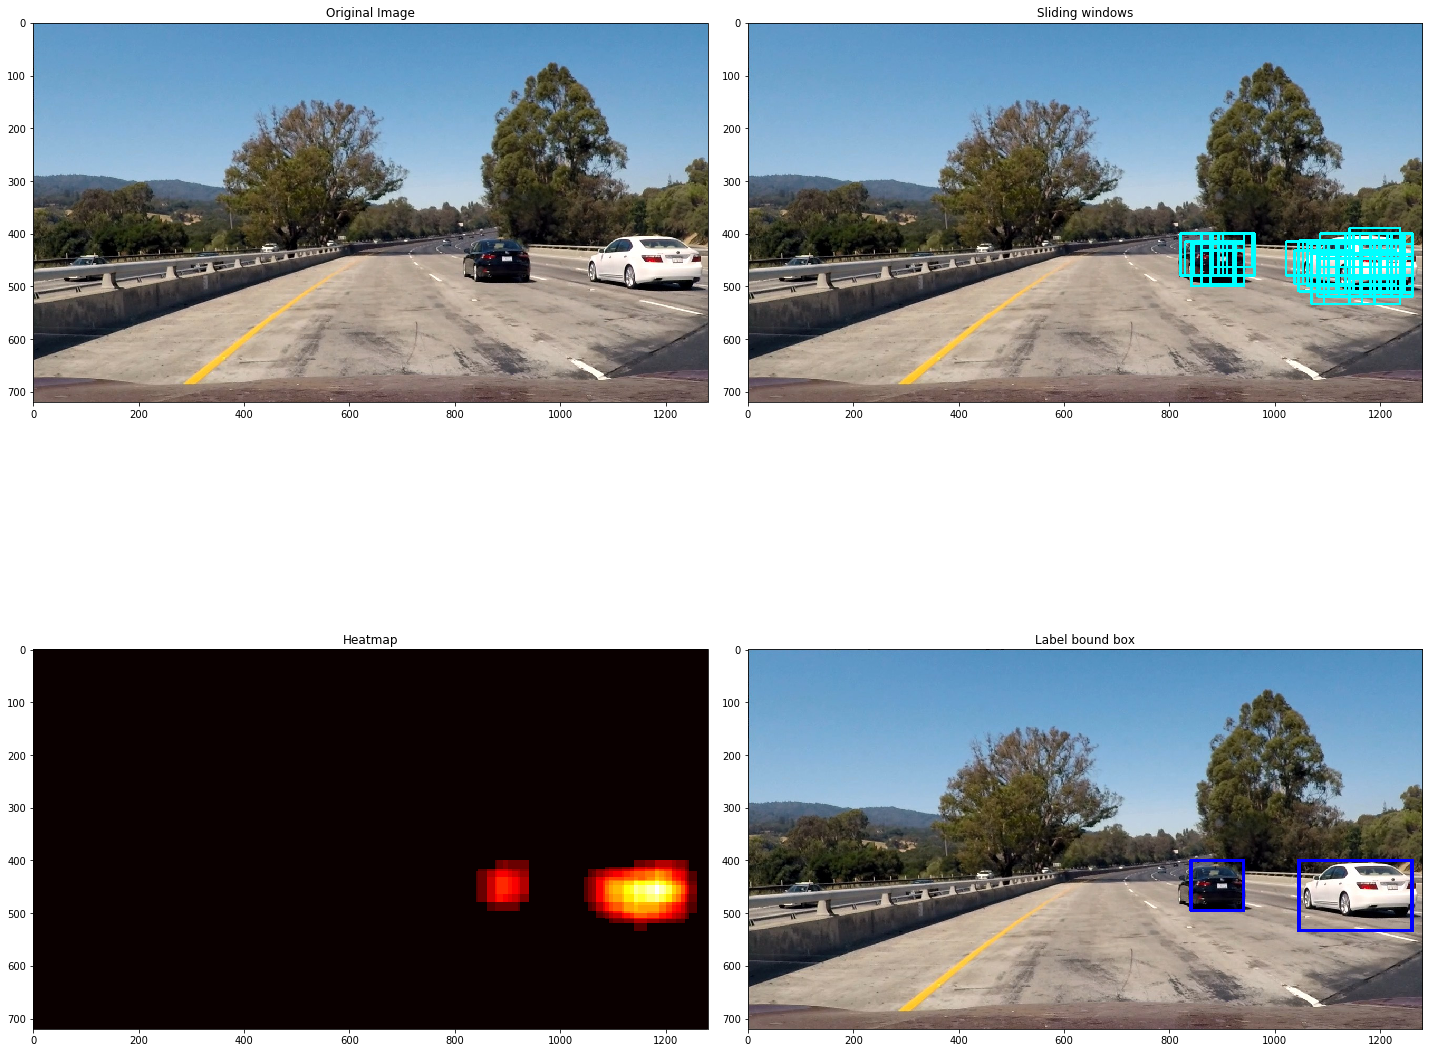

In [18]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = True

#Image 1
image = mpimg.imread('test_images/test1.jpg')
output, box_list = pipeline(image, True)



hot windows []
0


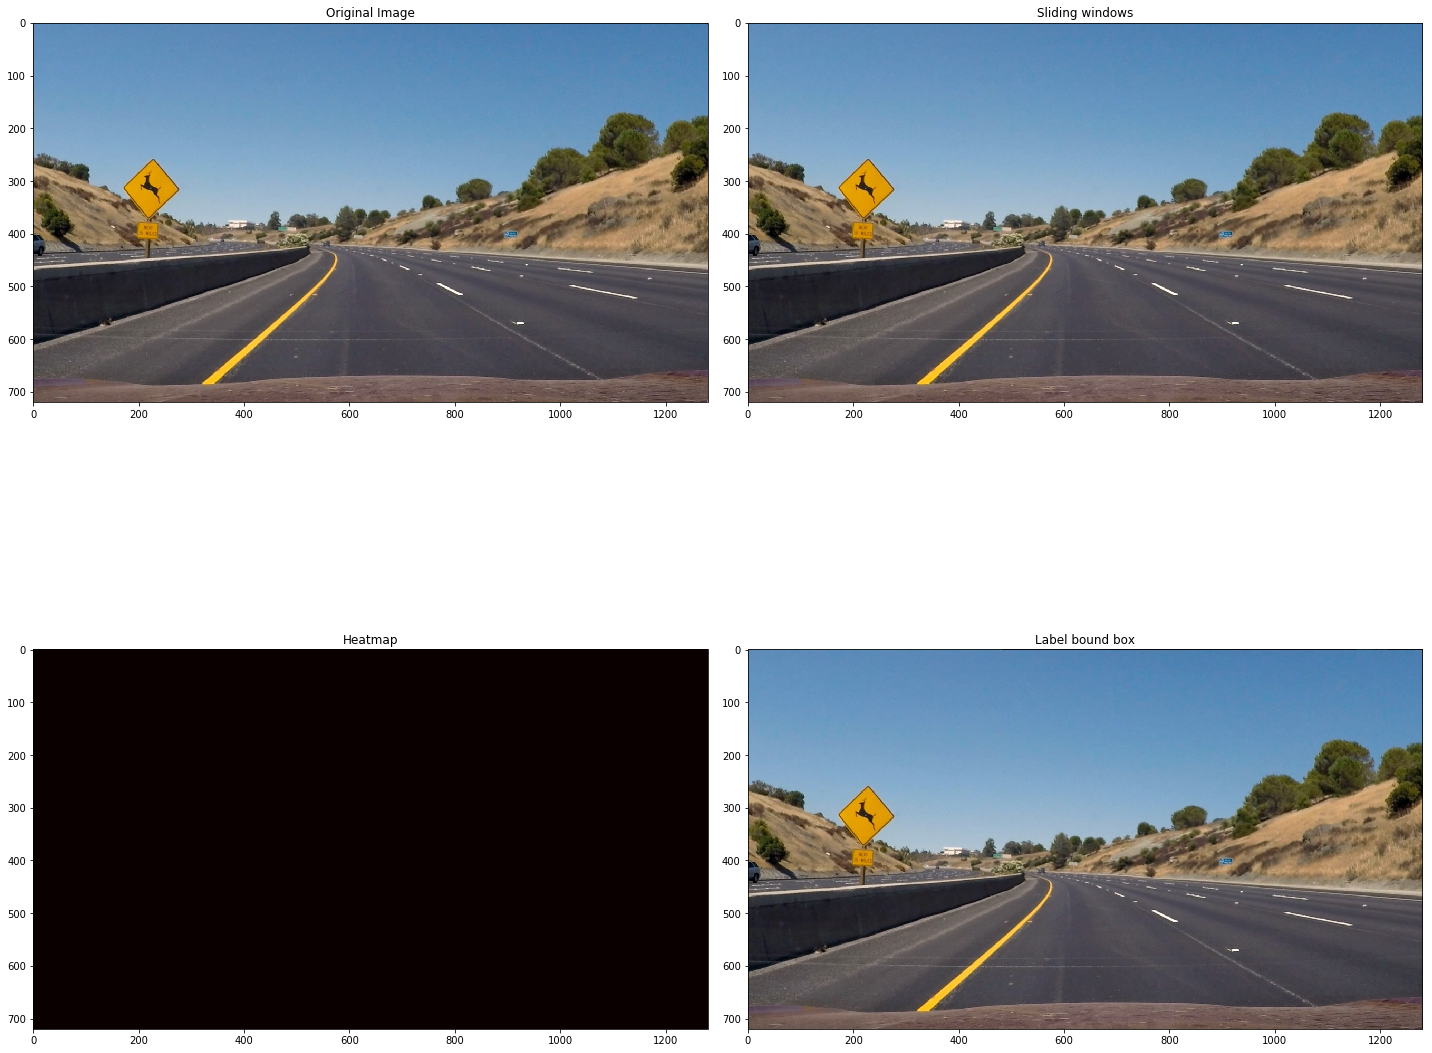

In [19]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = True

#Image 2
image = mpimg.imread('test_images/test2.jpg')
output, box_list = pipeline(image, True)


hot windows [((716, 416), (780, 480)), ((892, 400), (956, 464)), ((892, 416), (956, 480)), ((908, 416), (972, 480)), ((880, 400), (960, 480))]
1
 Found car #  1  in  ((892, 416), (955, 479))


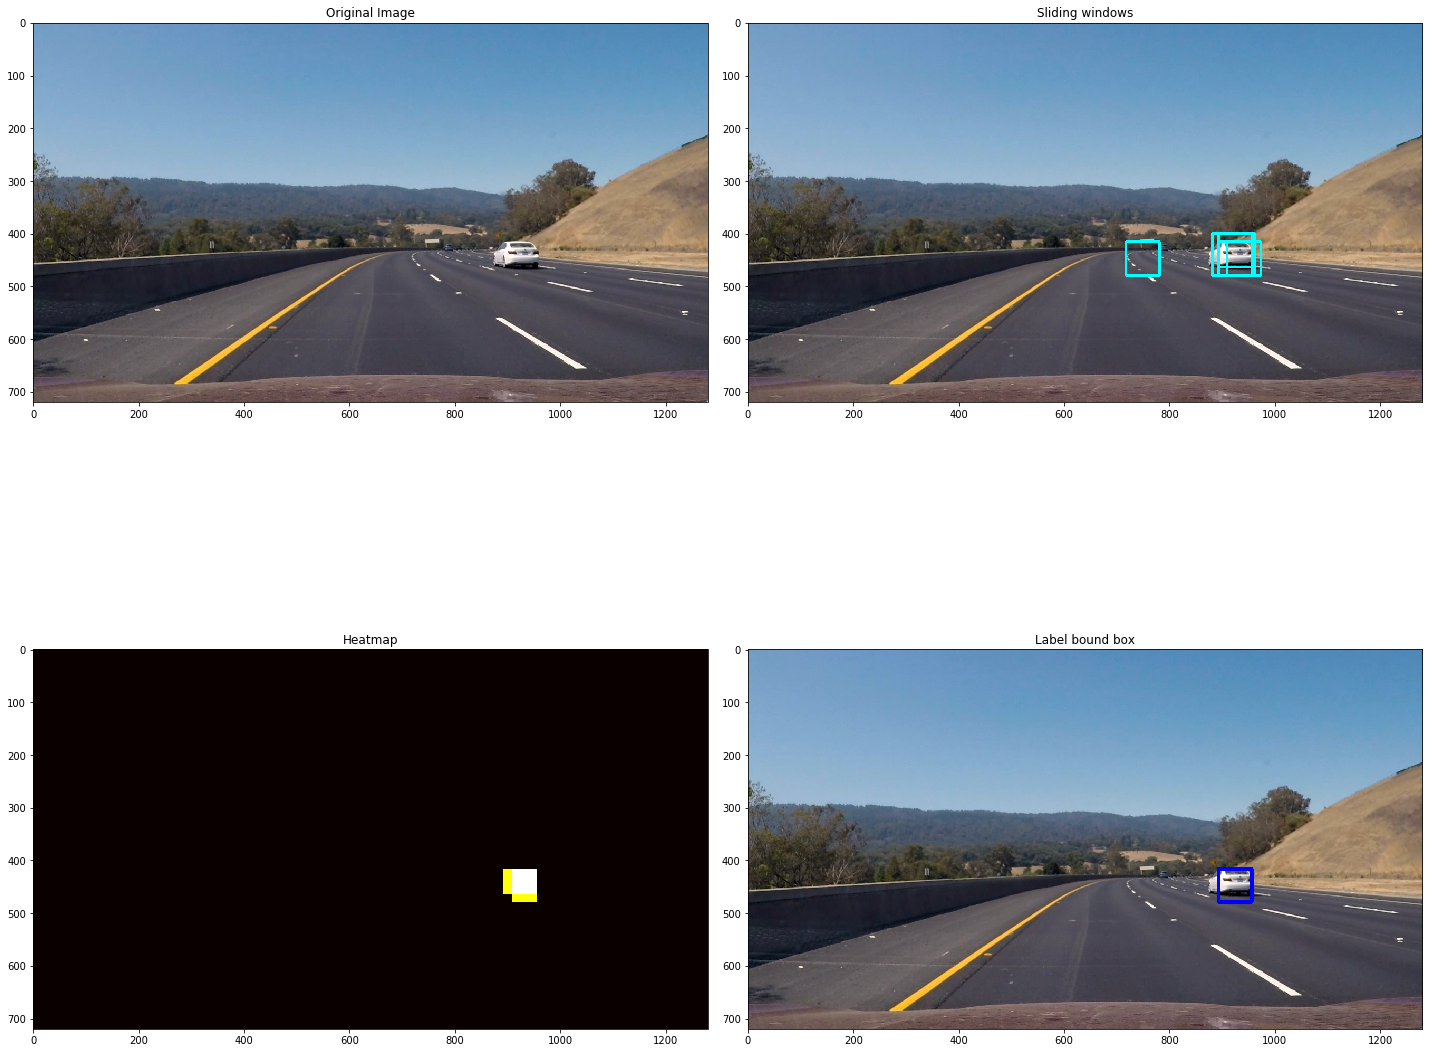

In [20]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = True

#Image 3
image = mpimg.imread('test_images/test3.jpg')
output, box_list = pipeline(image, True)


hot windows [((1044, 414), (1140, 510)), ((1068, 390), (1164, 486)), ((1092, 390), (1188, 486)), ((1092, 438), (1188, 534)), ((1116, 390), (1212, 486)), ((1116, 414), (1212, 510)), ((1140, 390), (1236, 486)), ((1140, 414), (1236, 510)), ((732, 608), (796, 672)), ((812, 416), (876, 480)), ((812, 576), (876, 640)), ((828, 416), (892, 480)), ((844, 416), (908, 480)), ((860, 400), (924, 464)), ((860, 416), (924, 480)), ((860, 432), (924, 496)), ((876, 400), (940, 464)), ((876, 432), (940, 496)), ((1004, 416), (1068, 480)), ((1036, 416), (1100, 480)), ((1036, 432), (1100, 496)), ((1052, 416), (1116, 480)), ((1052, 432), (1116, 496)), ((1052, 448), (1116, 512)), ((1068, 416), (1132, 480)), ((1068, 432), (1132, 496)), ((1068, 448), (1132, 512)), ((1100, 416), (1164, 480)), ((1100, 448), (1164, 512)), ((1116, 400), (1180, 464)), ((1116, 416), (1180, 480)), ((1116, 432), (1180, 496)), ((1116, 448), (1180, 512)), ((1132, 400), (1196, 464)), ((1132, 416), (1196, 480)), ((1132, 432), (1196, 496)),

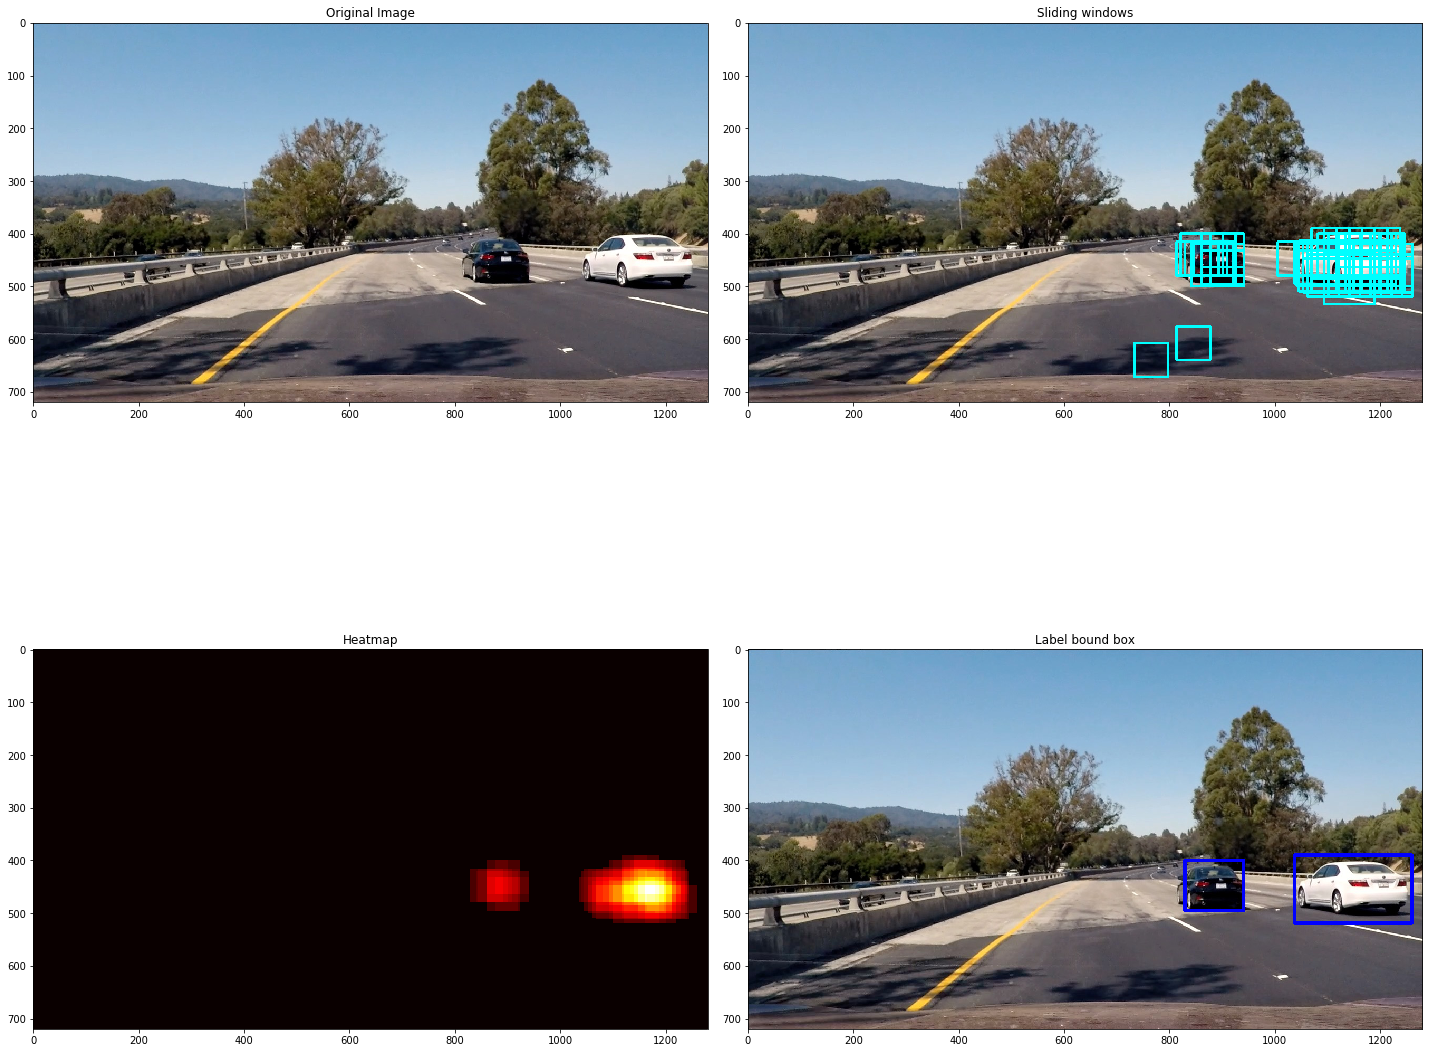

In [21]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = True

#Image 4
image = mpimg.imread('test_images/test4.jpg')
output, box_list = pipeline(image, True)


hot windows [((1092, 414), (1188, 510)), ((1116, 414), (1212, 510)), ((1116, 438), (1212, 534)), ((1140, 414), (1236, 510)), ((812, 416), (876, 480)), ((844, 416), (908, 480)), ((860, 400), (924, 464)), ((860, 416), (924, 480)), ((860, 432), (924, 496)), ((876, 416), (940, 480)), ((876, 432), (940, 496)), ((1084, 432), (1148, 496)), ((1100, 416), (1164, 480)), ((1116, 432), (1180, 496)), ((1132, 400), (1196, 464)), ((1132, 416), (1196, 480)), ((1148, 432), (1212, 496)), ((1164, 416), (1228, 480)), ((1164, 432), (1228, 496)), ((1164, 448), (1228, 512)), ((1164, 464), (1228, 528)), ((1180, 464), (1244, 528)), ((1196, 400), (1260, 464)), ((1196, 416), (1260, 480)), ((1196, 448), (1260, 512)), ((1196, 464), (1260, 528)), ((740, 420), (820, 500)), ((840, 400), (920, 480)), ((840, 420), (920, 500)), ((860, 400), (940, 480)), ((860, 420), (940, 500)), ((1080, 420), (1160, 500)), ((1100, 420), (1180, 500)), ((1120, 420), (1200, 500)), ((1160, 400), (1240, 480)), ((1160, 420), (1240, 500)), ((1

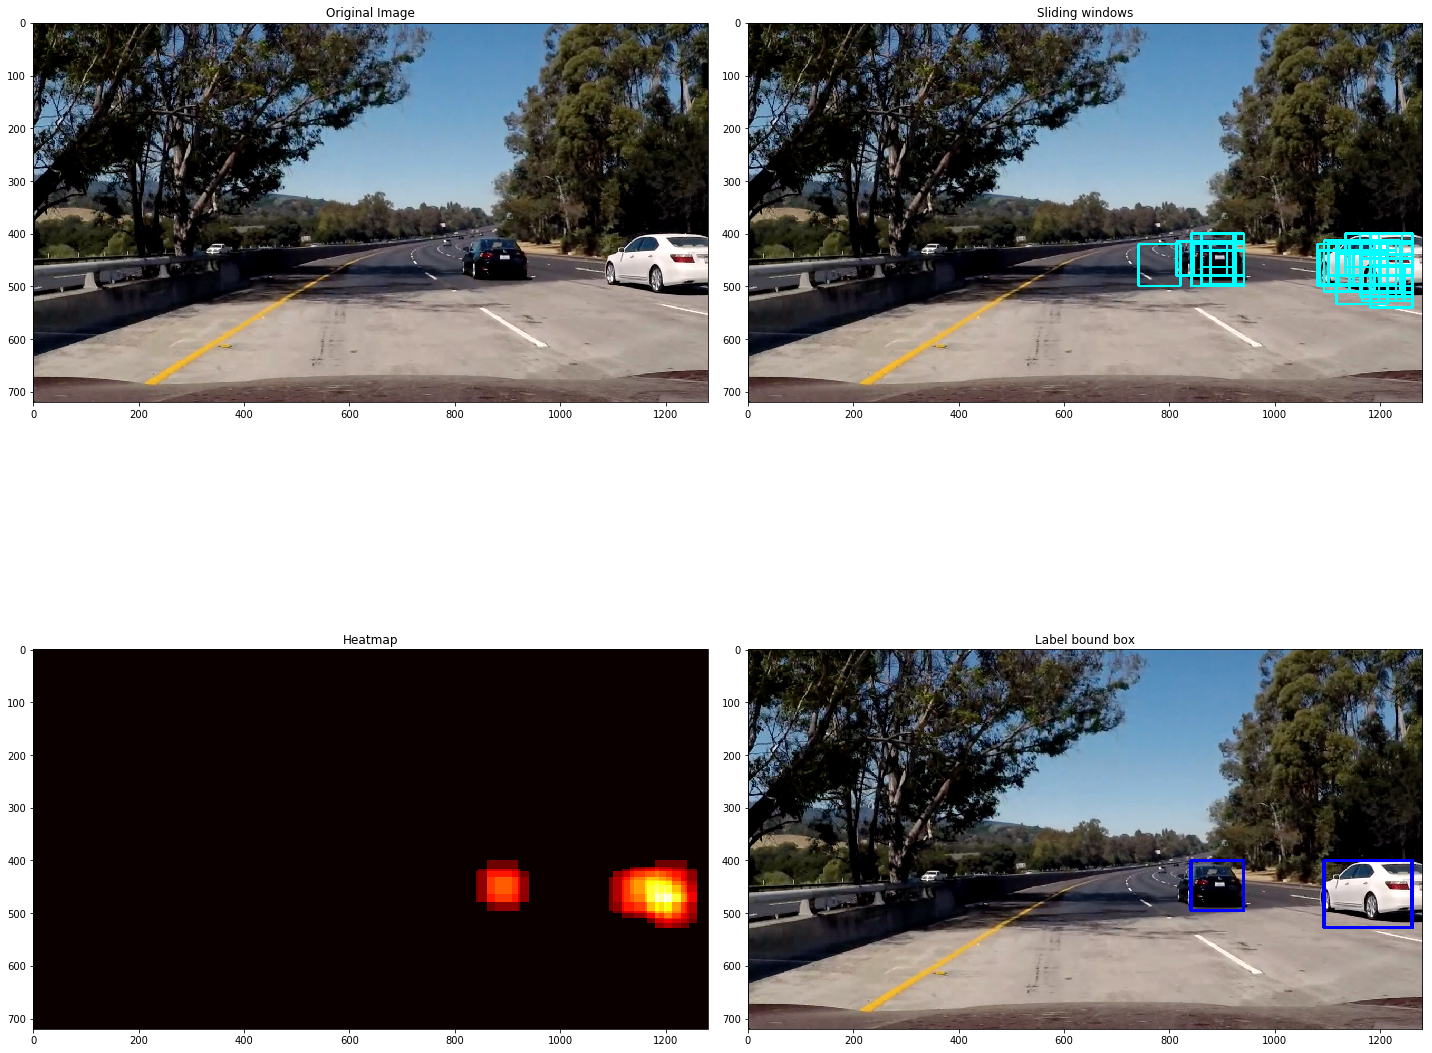

In [22]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = True

#Image 5
image = mpimg.imread('test_images/test5.jpg')
output, box_list = pipeline(image, True)


hot windows [((1020, 414), (1116, 510)), ((1044, 390), (1140, 486)), ((1044, 414), (1140, 510)), ((1068, 390), (1164, 486)), ((1068, 414), (1164, 510)), ((1092, 390), (1188, 486)), ((1092, 414), (1188, 510)), ((1116, 414), (1212, 510)), ((812, 416), (876, 480)), ((812, 432), (876, 496)), ((828, 400), (892, 464)), ((828, 416), (892, 480)), ((844, 416), (908, 480)), ((844, 432), (908, 496)), ((860, 400), (924, 464)), ((860, 416), (924, 480)), ((860, 432), (924, 496)), ((876, 400), (940, 464)), ((1004, 432), (1068, 496)), ((1020, 416), (1084, 480)), ((1020, 432), (1084, 496)), ((1036, 416), (1100, 480)), ((1036, 432), (1100, 496)), ((1068, 416), (1132, 480)), ((1068, 448), (1132, 512)), ((1084, 416), (1148, 480)), ((1084, 448), (1148, 512)), ((1100, 416), (1164, 480)), ((1100, 448), (1164, 512)), ((1116, 400), (1180, 464)), ((1116, 416), (1180, 480)), ((1116, 432), (1180, 496)), ((1116, 448), (1180, 512)), ((1132, 416), (1196, 480)), ((1132, 432), (1196, 496)), ((1132, 448), (1196, 512)),

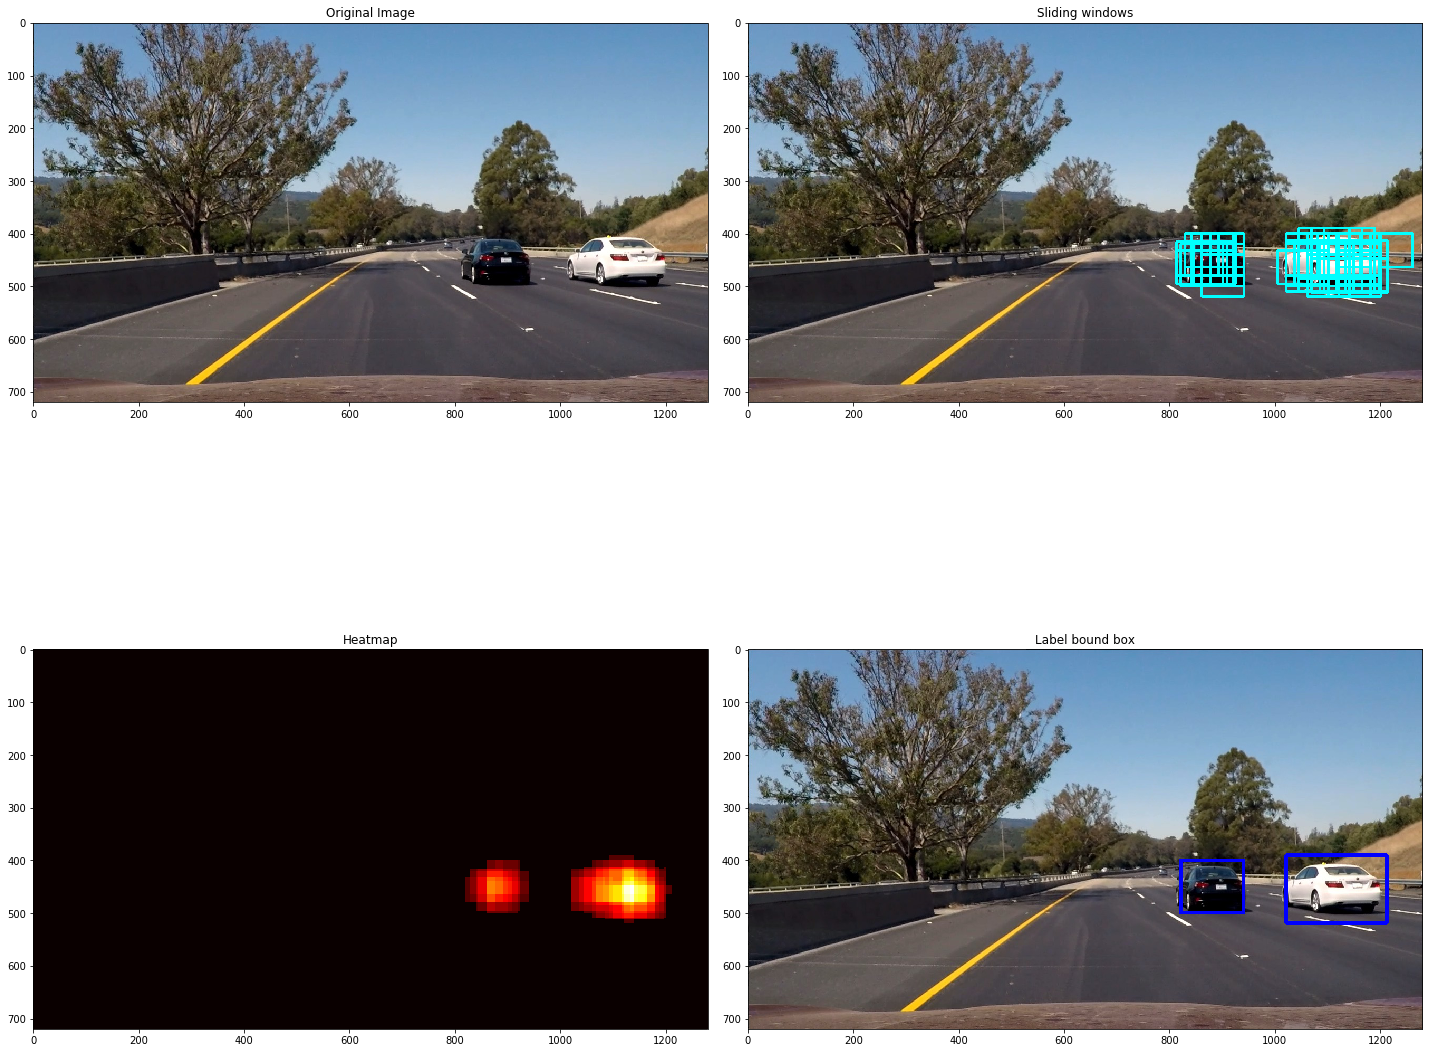

In [23]:
n_count = 0
prev_bboxes = []
#smoothing
heatmaps = []
heatmaps_avg_len = 5
vehicle_detected = True

#Image 6
image = mpimg.imread('test_images/test6.jpg')
output, box_list = pipeline(image, True)
